This notebook contains BDT variables distribution for different types of signals.

In [3]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import defaultdict_accumulator
import coffea.processor as processor
import uproot

import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.uproothelpers import NestNestObjArrayToJagged
from FireHydrant.Tools.metfilter import MetFilters

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

dataset=dict(
    sig4mu={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

for k in dataset4mu_: dataset['sig4mu']['files'].extend(dataset4mu_[k])
for k in dataset2mu2e_: dataset['sig2mu2e']['files'].extend(dataset2mu2e_[k])

### Let's plot leptonJets' pT again..

In [3]:
class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "signal")
        pt_axis = hist.Bin("pt", r"$p_T$ [GeV]", 50, 0, 800)
        multi_axis = hist.Bin("multi", "#leptonJets/event", 10, 0, 10)
        match_axis = hist.Cat('match', 'matched')
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("A.U.", dataset_axis, pt_axis, match_axis),
            'multi': hist.Hist("A.U.", dataset_axis, multi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        
        leptonjets_t = leptonjets[matchmask][metfiltermask]
        leptonjets_f = leptonjets[~matchmask][metfiltermask]

        output['pt'].fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['pt'].fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        
        output['multi'].fill(dataset=dataset, multi=leptonjets.counts)
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [5]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

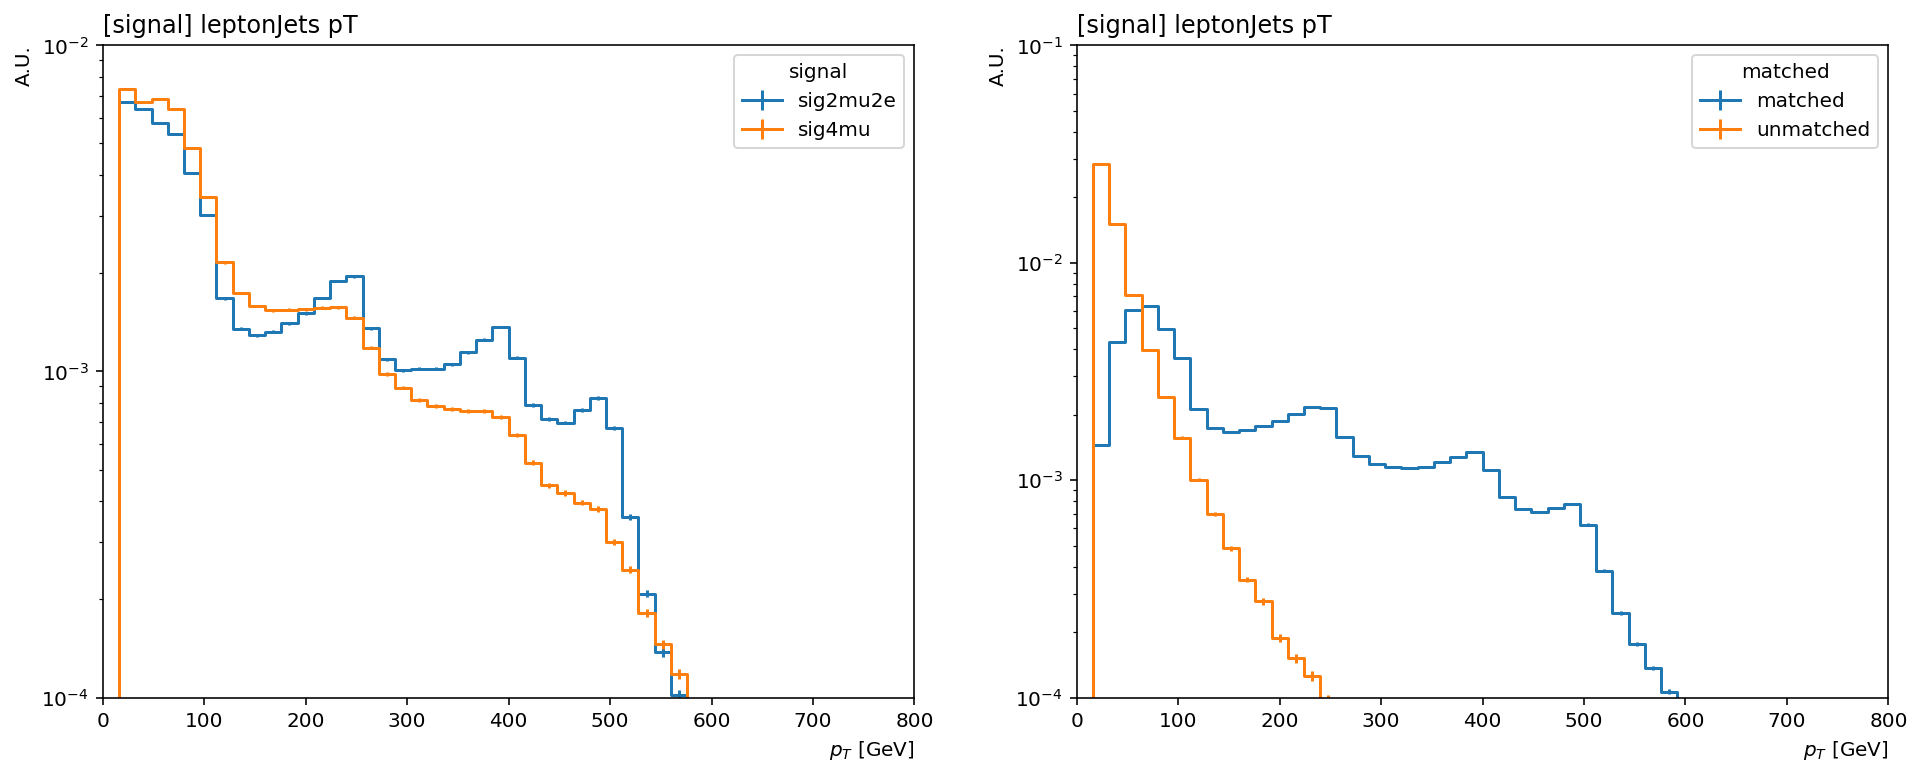

In [6]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets pT', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

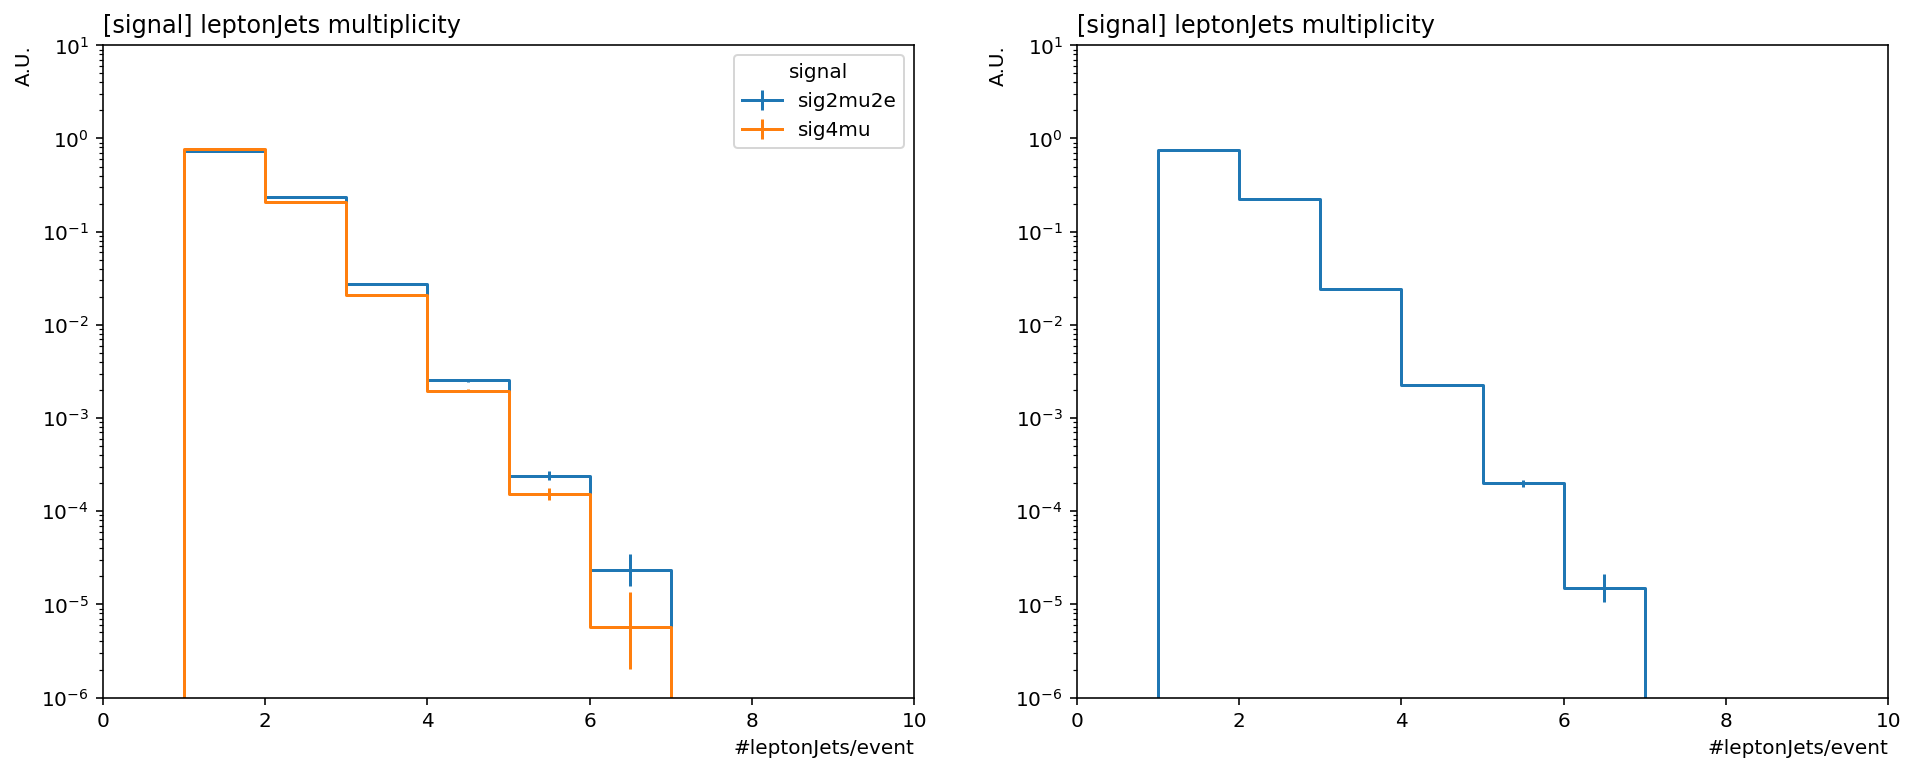

In [7]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['multi'], overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['multi'].project('dataset'), ax=axes[1], density=True)
axes[0].set_ylim([1e-6, 1e1])
axes[1].set_ylim([1e-6, 1e1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets multiplicity', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## Variables as input for BDT
- leptonJet pT, eta
- neutral energy fraction
- maxd0, mind0
- tkiso, pfiso
- spreadpt, spreaddr
- lambda, epsilon
- ecf 1,2,3

and
- BDT score

In [22]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'Control region')
        match_axis   = hist.Cat('match', 'matched')
        pt_axis       = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis      = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        nef_axis      = hist.Bin("nef", "neutral energy fraction", 50, 0, 1)
        maxd0_axis    = hist.Bin("maxd0", 'track max |d0|', 50, 0, 0.5)
        mind0_axis    = hist.Bin("mind0", 'track min |d0|', 50, 0, 0.5)
        tkiso_axis    = hist.Bin('tkiso', 'track isolation', 50, 0, 1)
        pfiso_axis    = hist.Bin("pfiso", "PFCands isolation", 50, 0, 1)
        spreadpt_axis = hist.Bin("spreadpt", "spreadpt", 50, 0, 1)
        spreaddr_axis = hist.Bin("spreaddr", "spreaddr", 50, 0, 0.1)
        lambda_axis   = hist.Bin('lamb', 'jet sub - lambda', 50, -8, 0)
        epsilon_axis  = hist.Bin('epsi', 'jet sub - epsilon', 50, 0, 0.25)
        ecfe1_axis    = hist.Bin('ecfe1', 'energy correlation function - e1', 50, 0, 200)
        ecfe2_axis    = hist.Bin('ecfe2', 'energy correlation function - e2', 50, 0, 500)
        ecfe3_axis    = hist.Bin('ecfe3', 'energy correlation function - e3', 50, 0, 300)
        mva_axis      = hist.Bin('mva', 'BDT value', 50, -10, 10)
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("#counts/16GeV", dataset_axis, pt_axis, match_axis),
            "eta": hist.Hist("#counts/0.096", dataset_axis, eta_axis, match_axis),
            "nef": hist.Hist("#counts/0.02", dataset_axis, nef_axis, match_axis),
            "maxd0": hist.Hist("#counts/0.01cm", dataset_axis, maxd0_axis, match_axis),
            "mind0": hist.Hist("#counts/0.01cm", dataset_axis, mind0_axis, match_axis),
            "tkiso": hist.Hist("#counts/0.02", dataset_axis, tkiso_axis, match_axis),
            "pfiso": hist.Hist("#counts/0.02", dataset_axis, pfiso_axis, match_axis),
            "spreadpt": hist.Hist("#counts/0.02", dataset_axis, spreadpt_axis, match_axis),
            "spreaddr": hist.Hist("#counts/0.002", dataset_axis, spreaddr_axis, match_axis),
            "lamb": hist.Hist("#counts/0.16", dataset_axis, lambda_axis, match_axis),
            "epsi": hist.Hist("#counts/0.005", dataset_axis, epsilon_axis, match_axis),
            "ecfe1": hist.Hist("#counts/4", dataset_axis, ecfe1_axis, match_axis),
            "ecfe2": hist.Hist("#counts/10", dataset_axis, ecfe2_axis, match_axis),
            "ecfe3": hist.Hist("#counts/6", dataset_axis, ecfe3_axis, match_axis),
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, match_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        maxd0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).max()
        mind0_ = np.abs(NestNestObjArrayToJagged(df['pfjet_pfcand_tkD0'])).fillna(0).min()
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT'],
            maxd0=maxd0_.content,
            mind0=mind0_.content,
            tkiso=df['pfjet_tkIsolation05'],
            pfiso=df['pfjet_pfIsolation05'],
            spreadpt=df['pfjet_ptDistribution'],
            spreaddr=df['pfjet_dRSpread'],
            lamb=df['pfjet_subjet_lambda'],
            epsi=df['pfjet_subjet_epsilon'],
            ecf1=df['pfjet_subjet_ecf1'],
            ecf2=df['pfjet_subjet_ecf2'],
            ecf3=df['pfjet_subjet_ecf3'],
            mva=df['pfjet_mva'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        
        leptonjets_t = leptonjets[matchmask][metfiltermask]
        leptonjets_f = leptonjets[~matchmask][metfiltermask]

        
        output['pt']      .fill(dataset=dataset, match='matched', pt=leptonjets_t.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='matched', eta=leptonjets_t.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='matched', nef=leptonjets_t.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='matched', maxd0=leptonjets_t.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='matched', mind0=leptonjets_t.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='matched', tkiso=leptonjets_t.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='matched', pfiso=leptonjets_t.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='matched', spreadpt=leptonjets_t.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='matched', spreaddr=leptonjets_t.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='matched', lamb=leptonjets_t.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='matched', epsi=leptonjets_t.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='matched', ecfe1=leptonjets_t.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='matched', ecfe2=leptonjets_t.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='matched', ecfe3=leptonjets_t.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='matched', mva=leptonjets_t.mva.flatten())
        
        output['pt']      .fill(dataset=dataset, match='unmatched', pt=leptonjets_f.pt.flatten())
        output['eta']     .fill(dataset=dataset, match='unmatched', eta=leptonjets_f.eta.flatten())
        output['nef']     .fill(dataset=dataset, match='unmatched', nef=leptonjets_f.nef.flatten())
        output['maxd0']   .fill(dataset=dataset, match='unmatched', maxd0=leptonjets_f.maxd0.flatten())
        output['mind0']   .fill(dataset=dataset, match='unmatched', mind0=leptonjets_f.mind0.flatten())
        output['tkiso']   .fill(dataset=dataset, match='unmatched', tkiso=leptonjets_f.tkiso.flatten())
        output['pfiso']   .fill(dataset=dataset, match='unmatched', pfiso=leptonjets_f.pfiso.flatten())
        output['spreadpt'].fill(dataset=dataset, match='unmatched', spreadpt=leptonjets_f.spreadpt.flatten())
        output['spreaddr'].fill(dataset=dataset, match='unmatched', spreaddr=leptonjets_f.spreaddr.flatten())
        output['lamb']    .fill(dataset=dataset, match='unmatched', lamb=leptonjets_f.lamb.flatten())
        output['epsi']    .fill(dataset=dataset, match='unmatched', epsi=leptonjets_f.epsi.flatten())
        output['ecfe1']   .fill(dataset=dataset, match='unmatched', ecfe1=leptonjets_f.ecf1.flatten())
        output['ecfe2']   .fill(dataset=dataset, match='unmatched', ecfe2=leptonjets_f.ecf2.flatten())
        output['ecfe3']   .fill(dataset=dataset, match='unmatched', ecfe3=leptonjets_f.ecf3.flatten())
        output['mva']     .fill(dataset=dataset, match='unmatched', mva=leptonjets_f.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [23]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

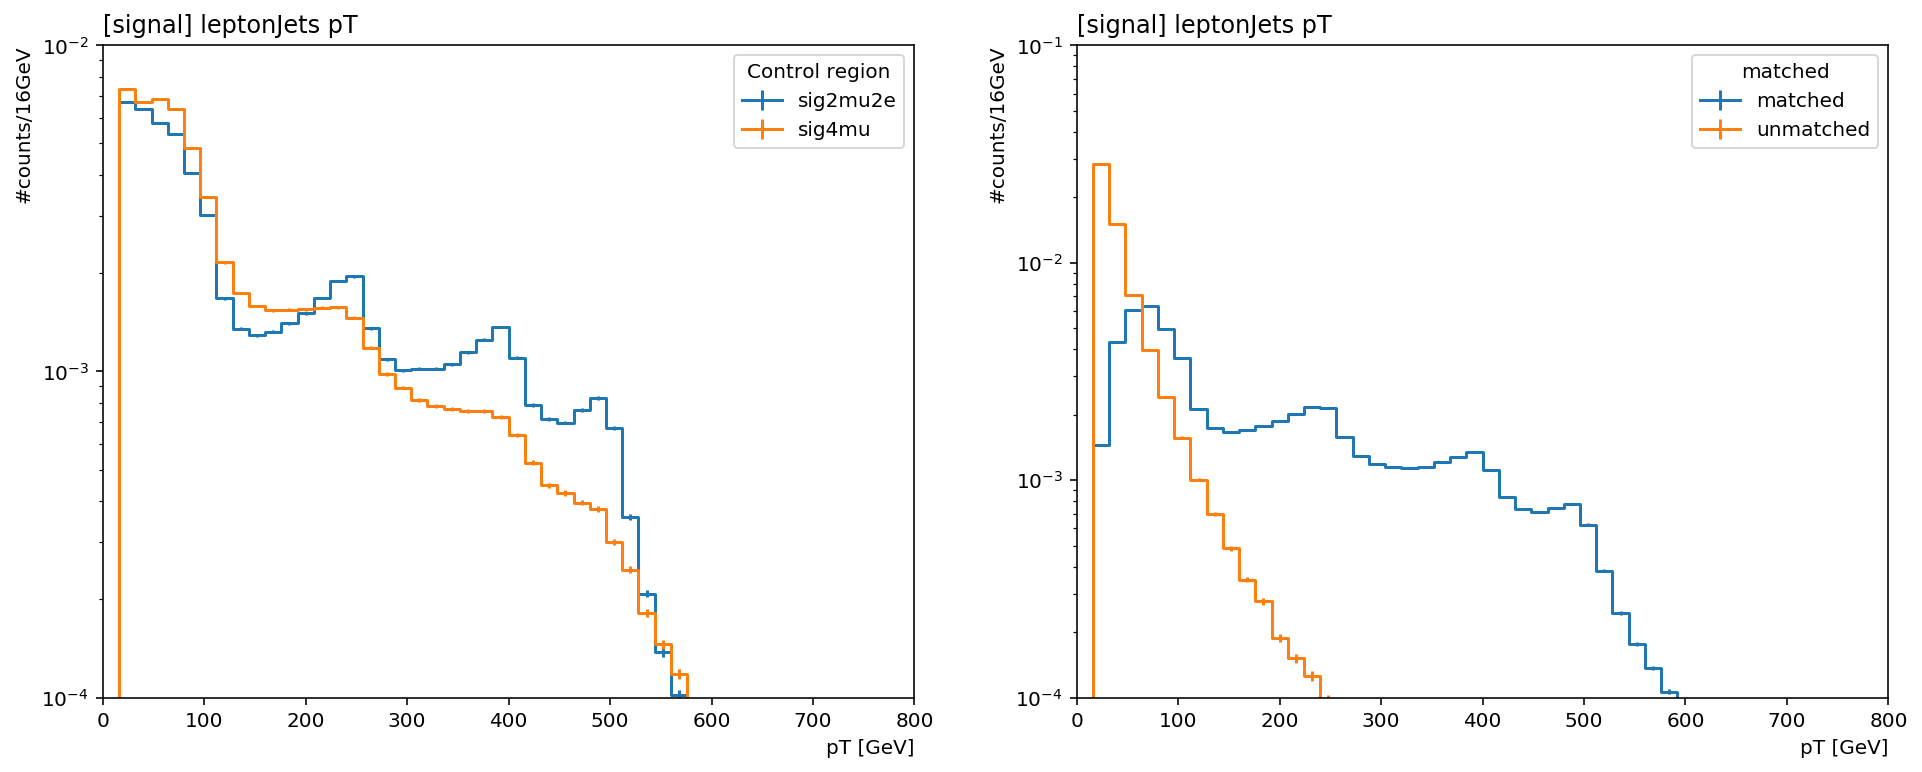

In [10]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-4, 1e-2])
axes[1].set_ylim([1e-4, 1e-1])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets pT', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

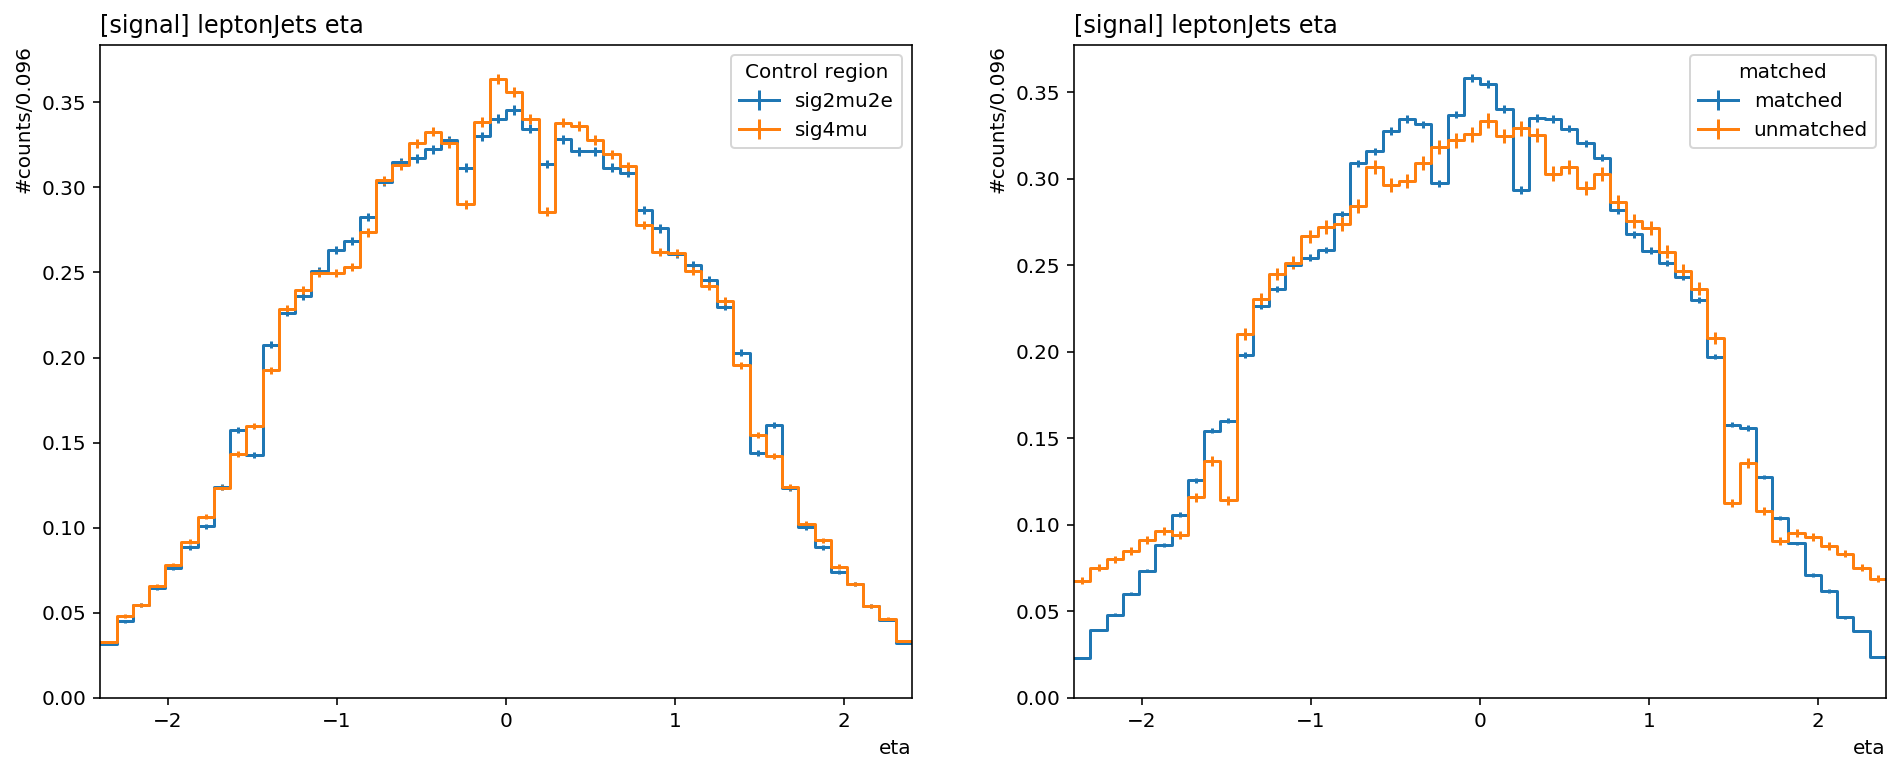

In [11]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['eta'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['eta'].project('dataset'), overlay='match', ax=axes[1], density=True)


for ax in axes:
    ax.set_title('[signal] leptonJets eta', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

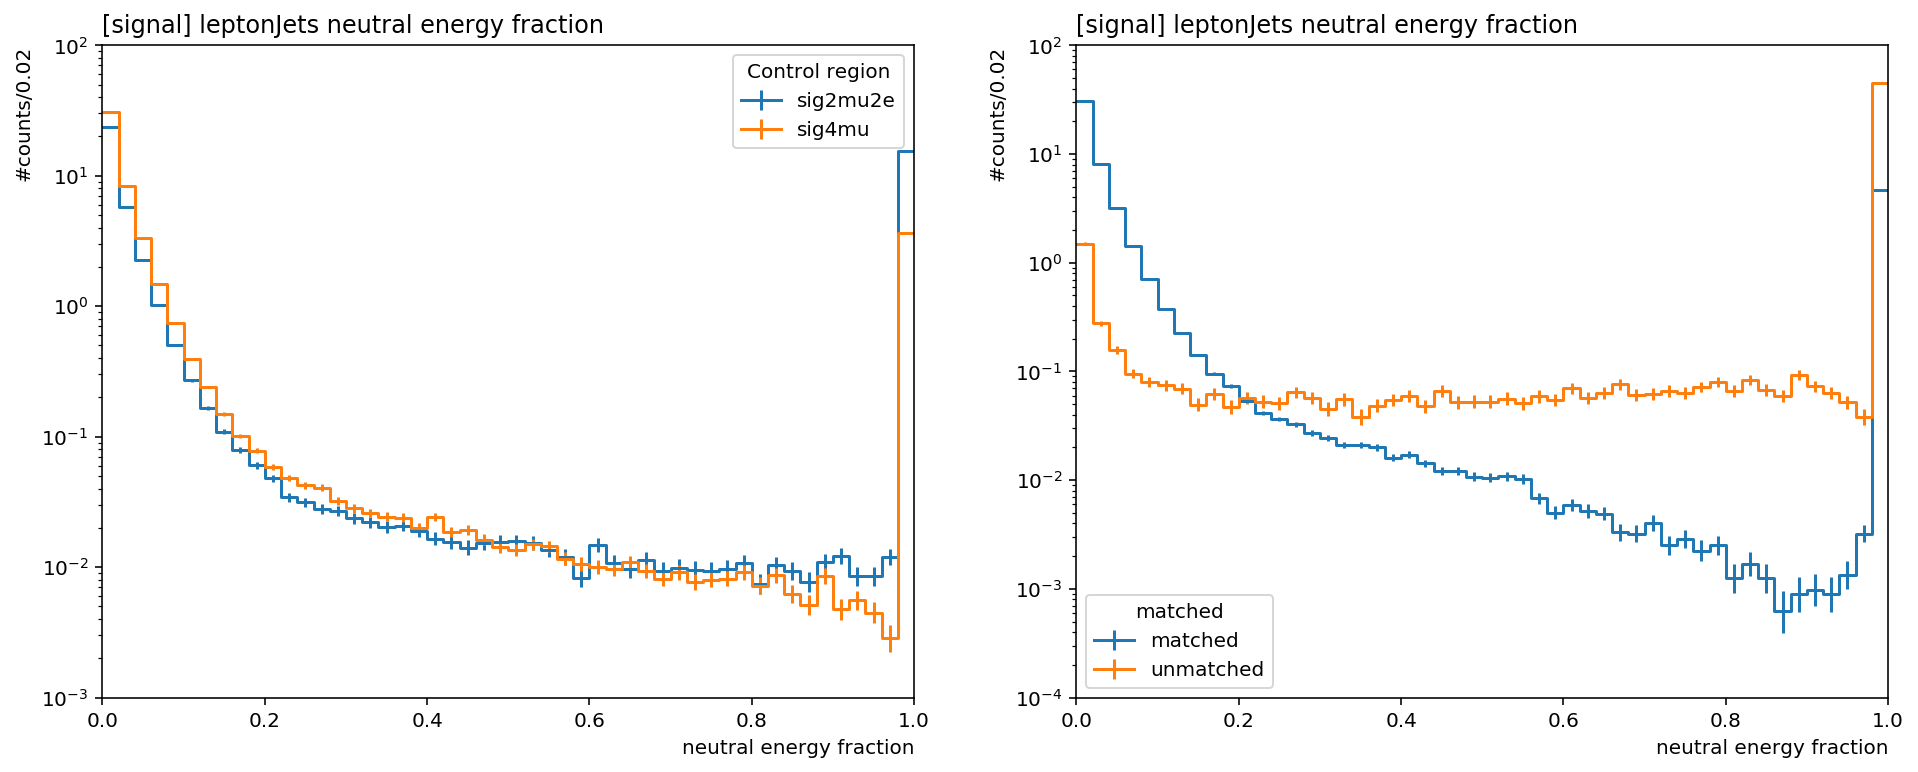

In [12]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['nef'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['nef'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-3, 1e2])
axes[1].set_ylim([1e-4, 1e2])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets neutral energy fraction', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

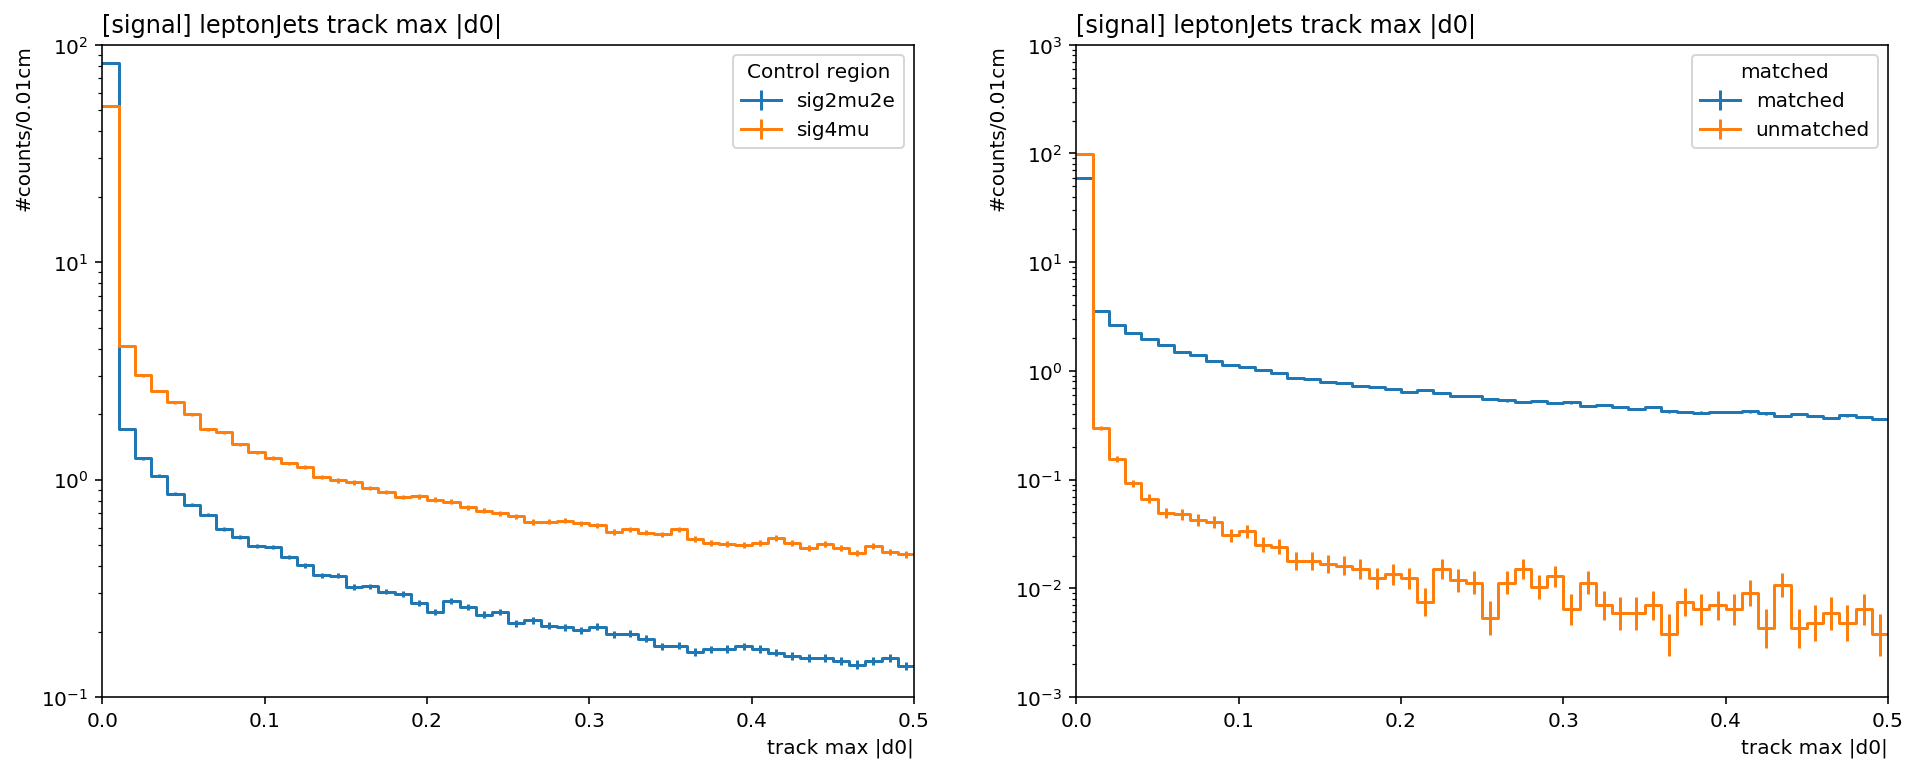

In [24]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['maxd0'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['maxd0'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-1, 1e2])
axes[1].set_ylim([1e-3, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets track max |d0|', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

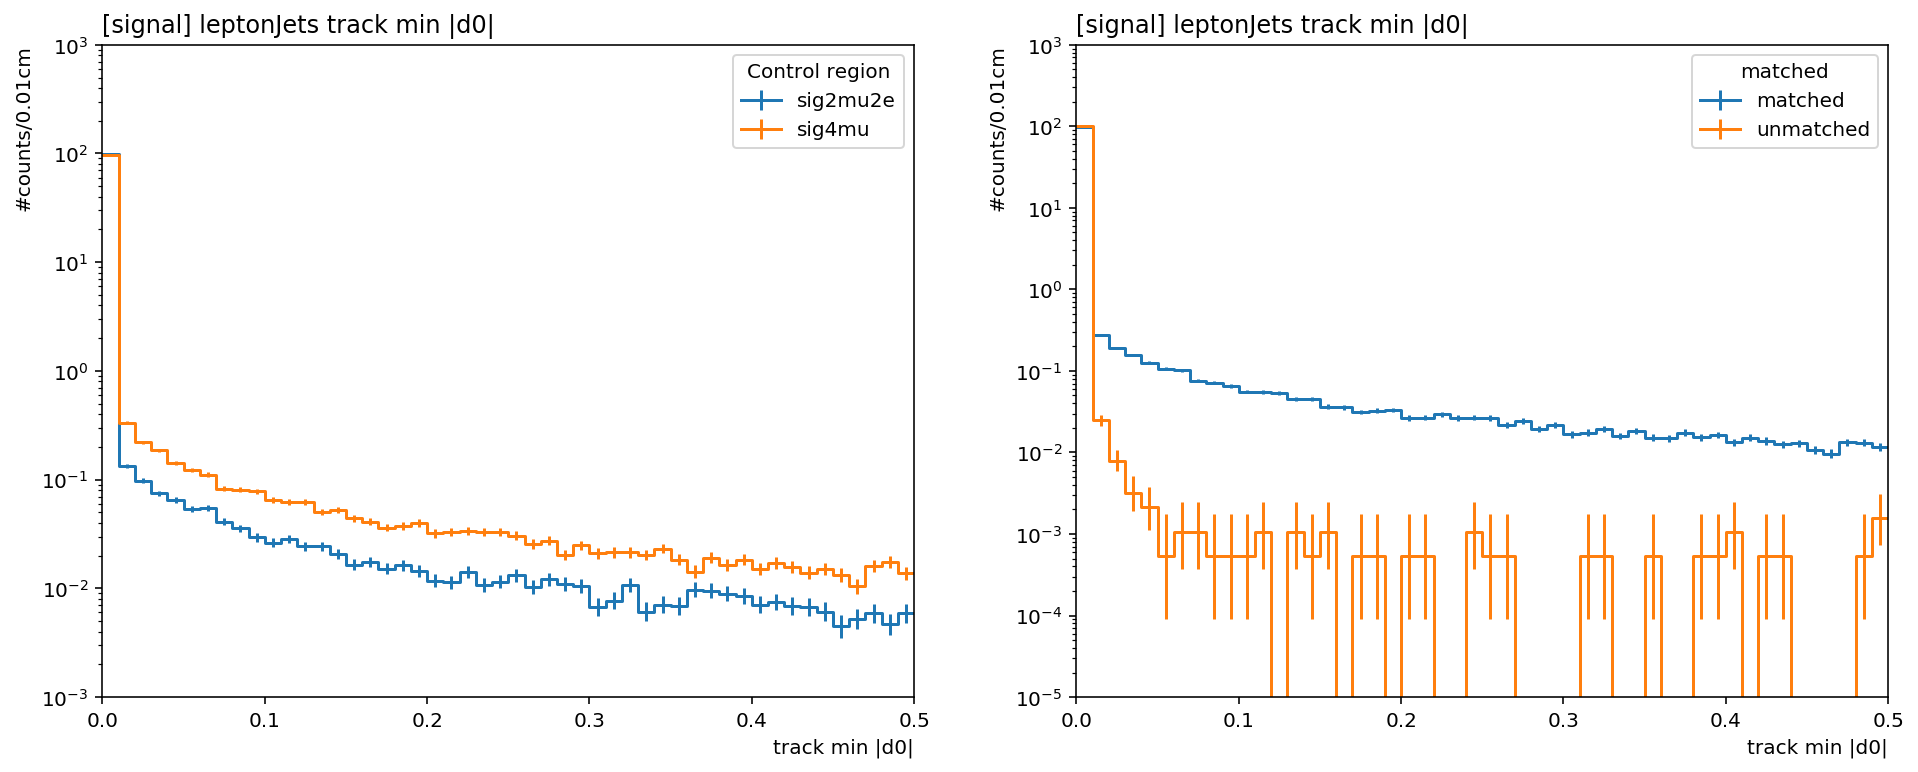

In [25]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mind0'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['mind0'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-3, 1e3])
axes[1].set_ylim([1e-5, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets track min |d0|', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

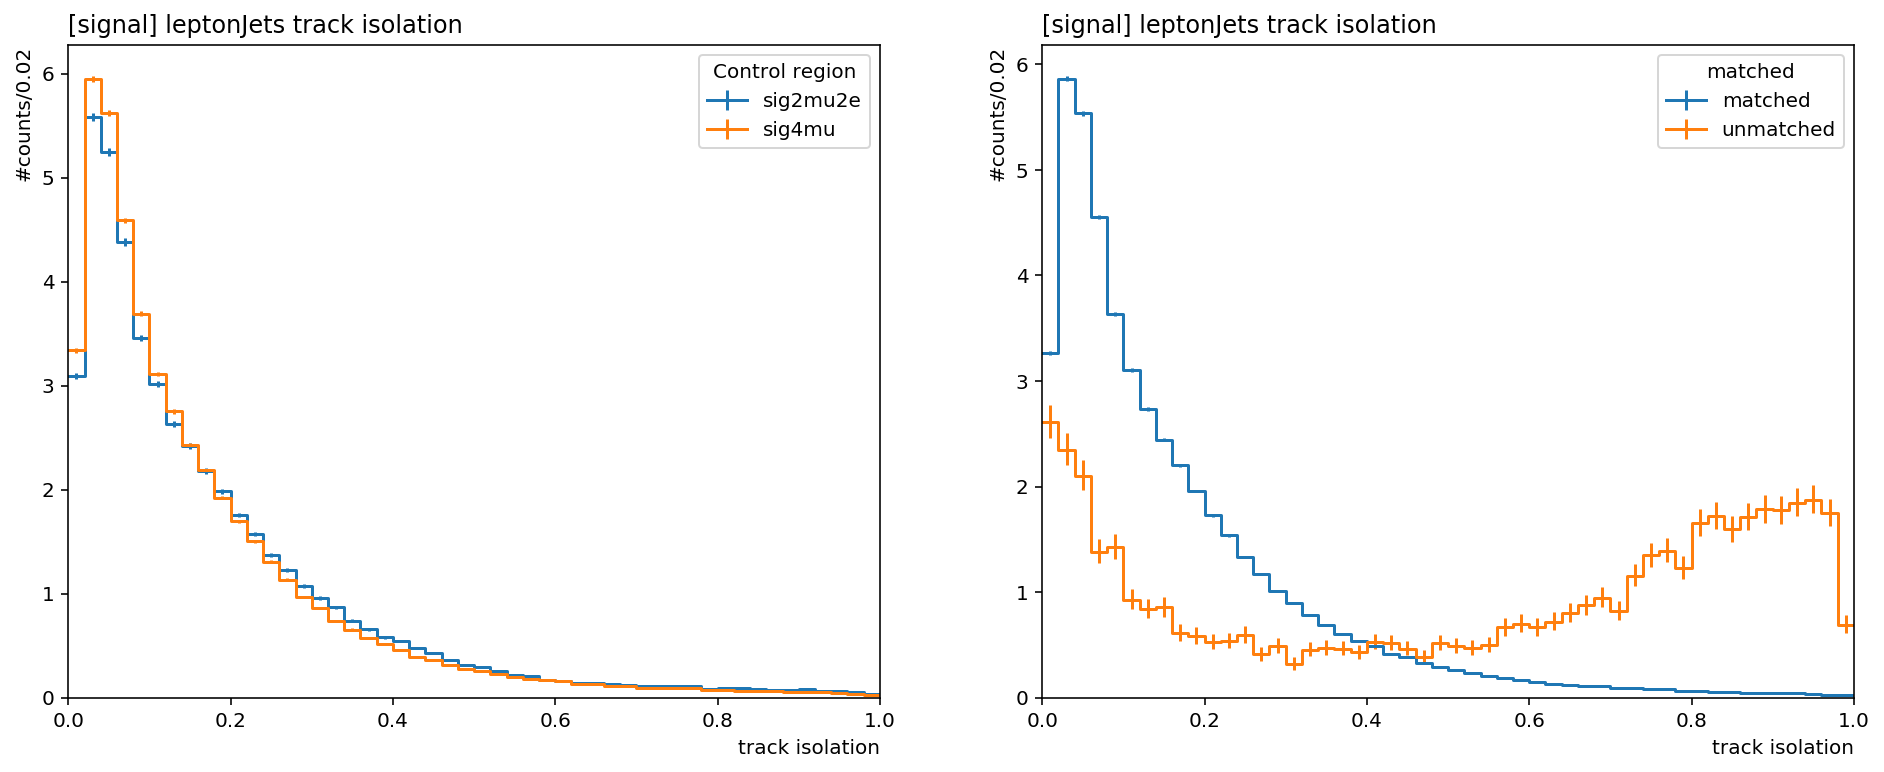

In [15]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['tkiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['tkiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets track isolation', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

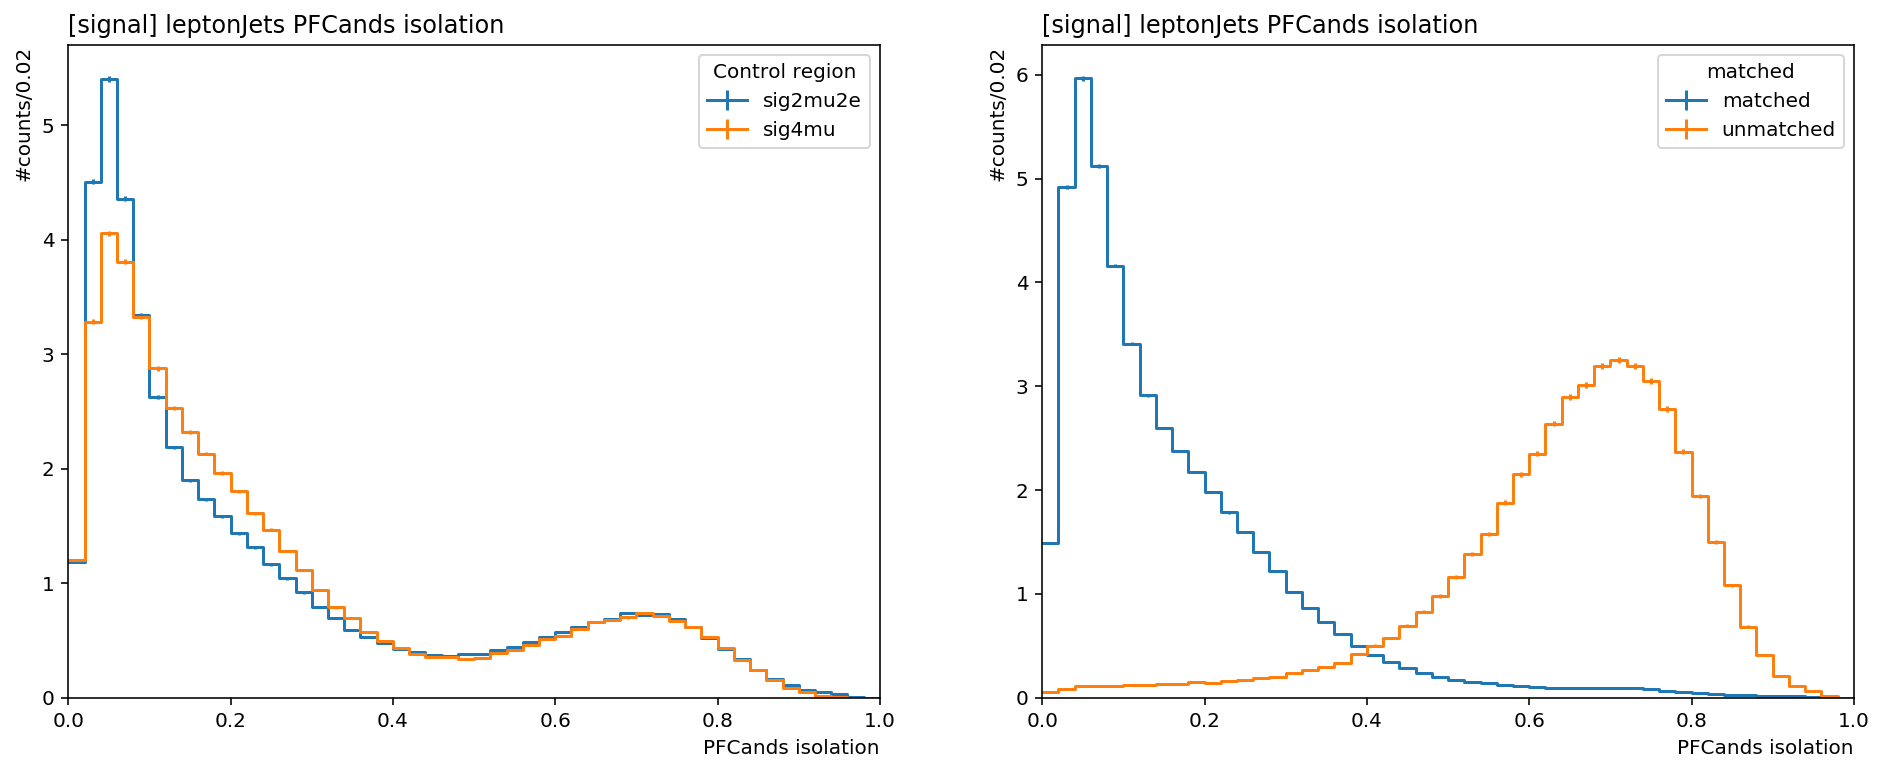

In [16]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['pfiso'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['pfiso'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets PFCands isolation', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

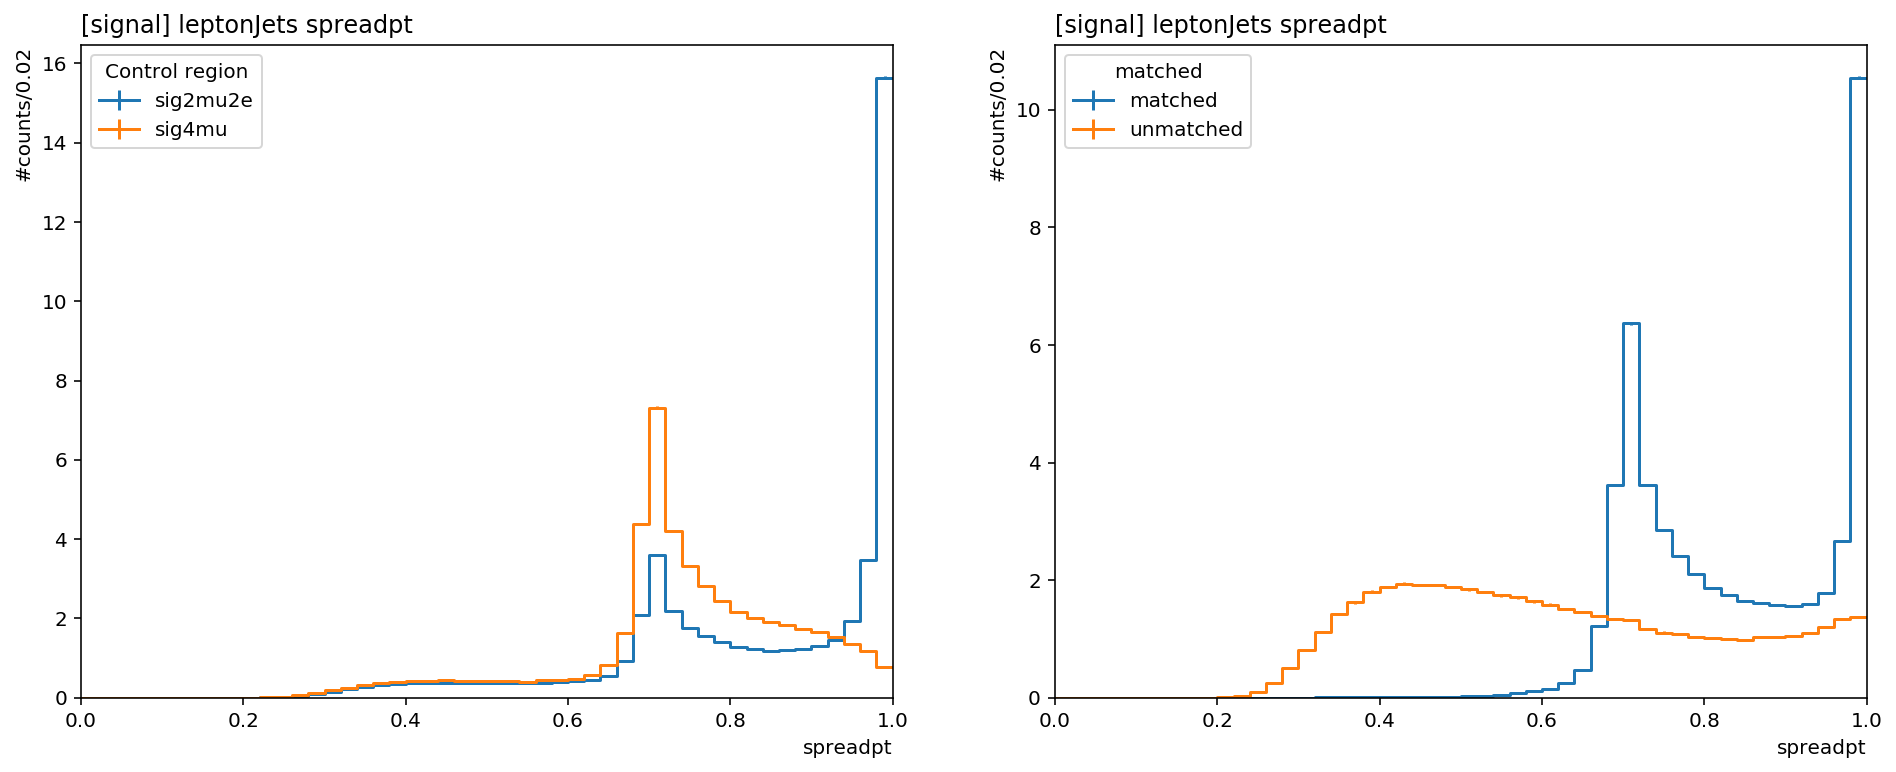

In [17]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreadpt'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreadpt'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets spreadpt', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

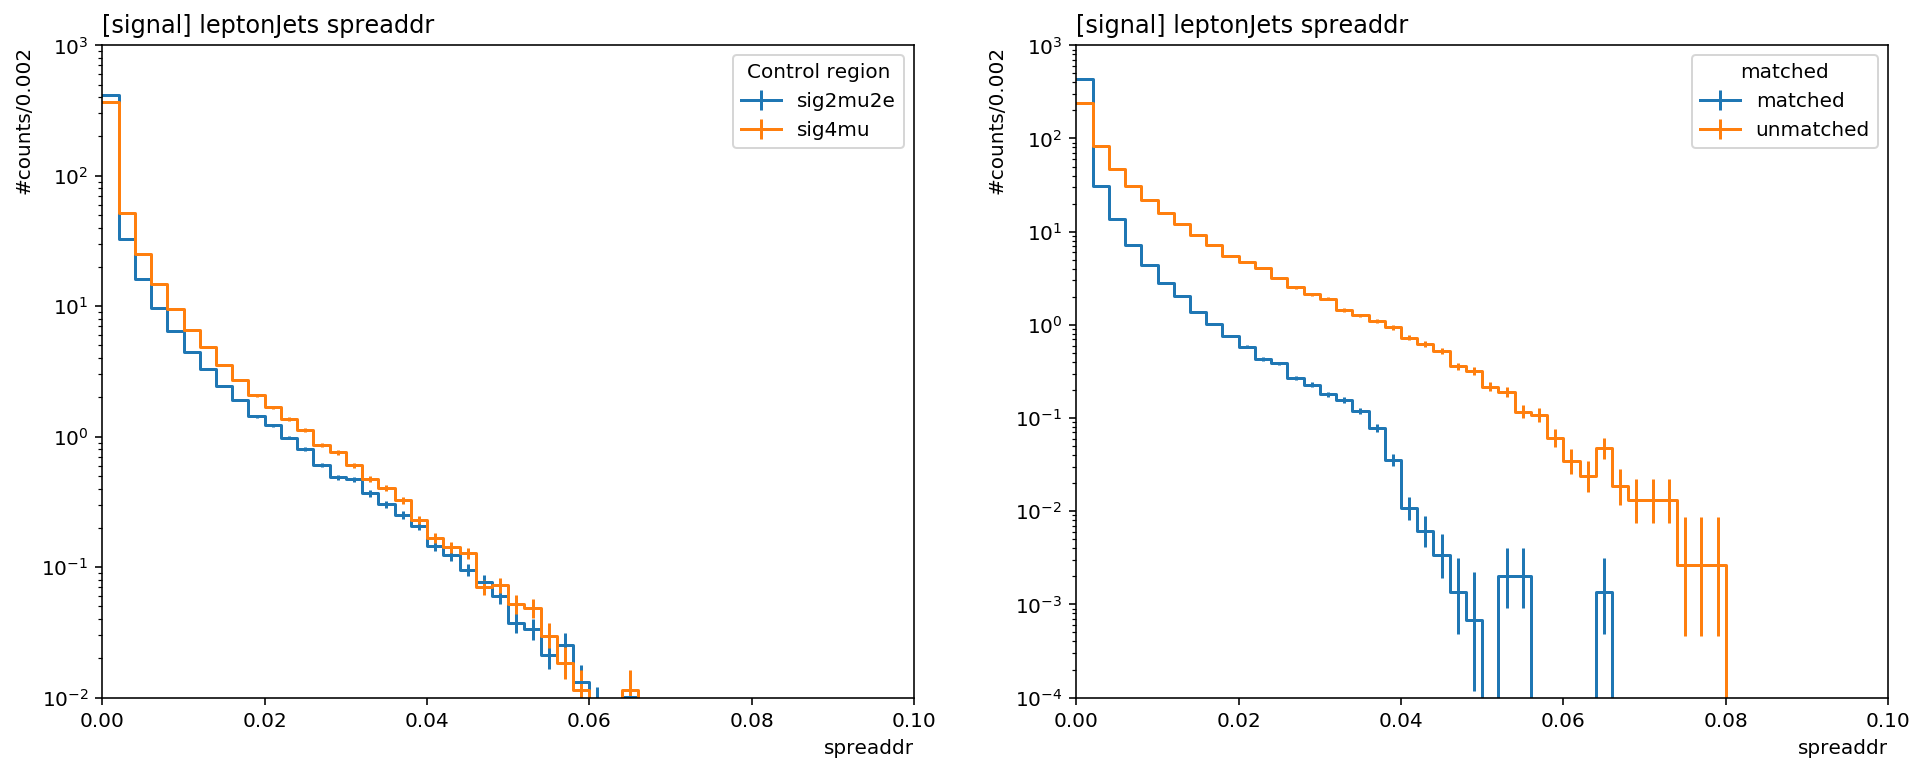

In [18]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['spreaddr'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['spreaddr'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-2, 1e3])
axes[1].set_ylim([1e-4, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets spreaddr', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

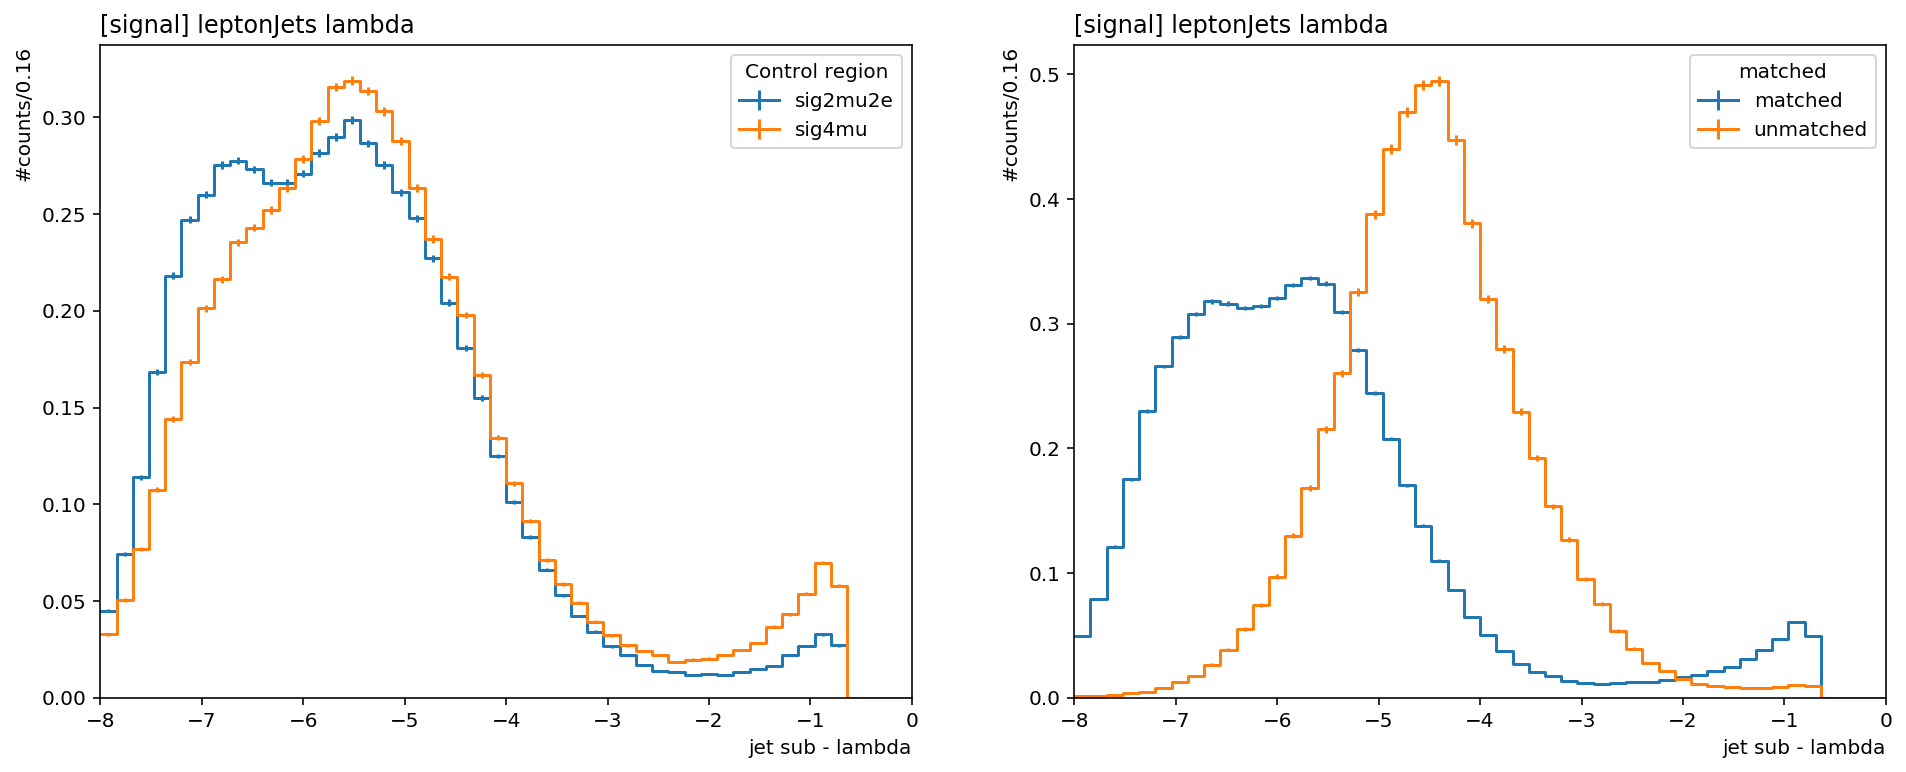

In [19]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['lamb'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['lamb'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets lambda', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

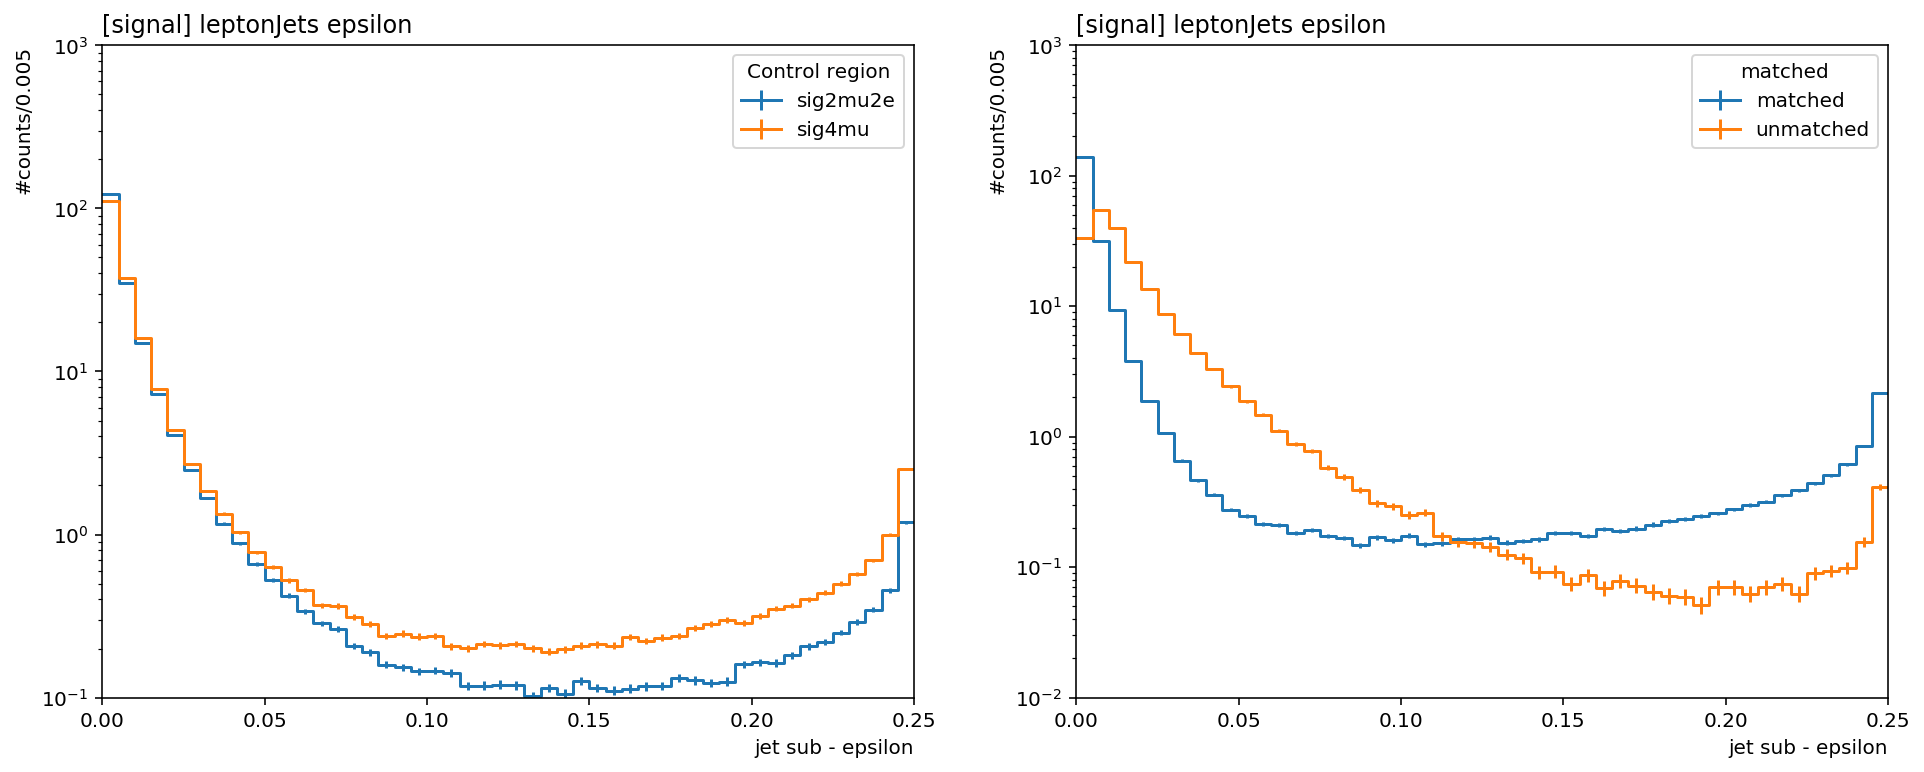

In [20]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['epsi'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['epsi'].project('dataset'), overlay='match', ax=axes[1], density=True)
axes[0].set_ylim([1e-1, 1e3])
axes[1].set_ylim([1e-2, 1e3])

for ax in axes:
    ax.set_yscale('log')
    ax.set_title('[signal] leptonJets epsilon', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

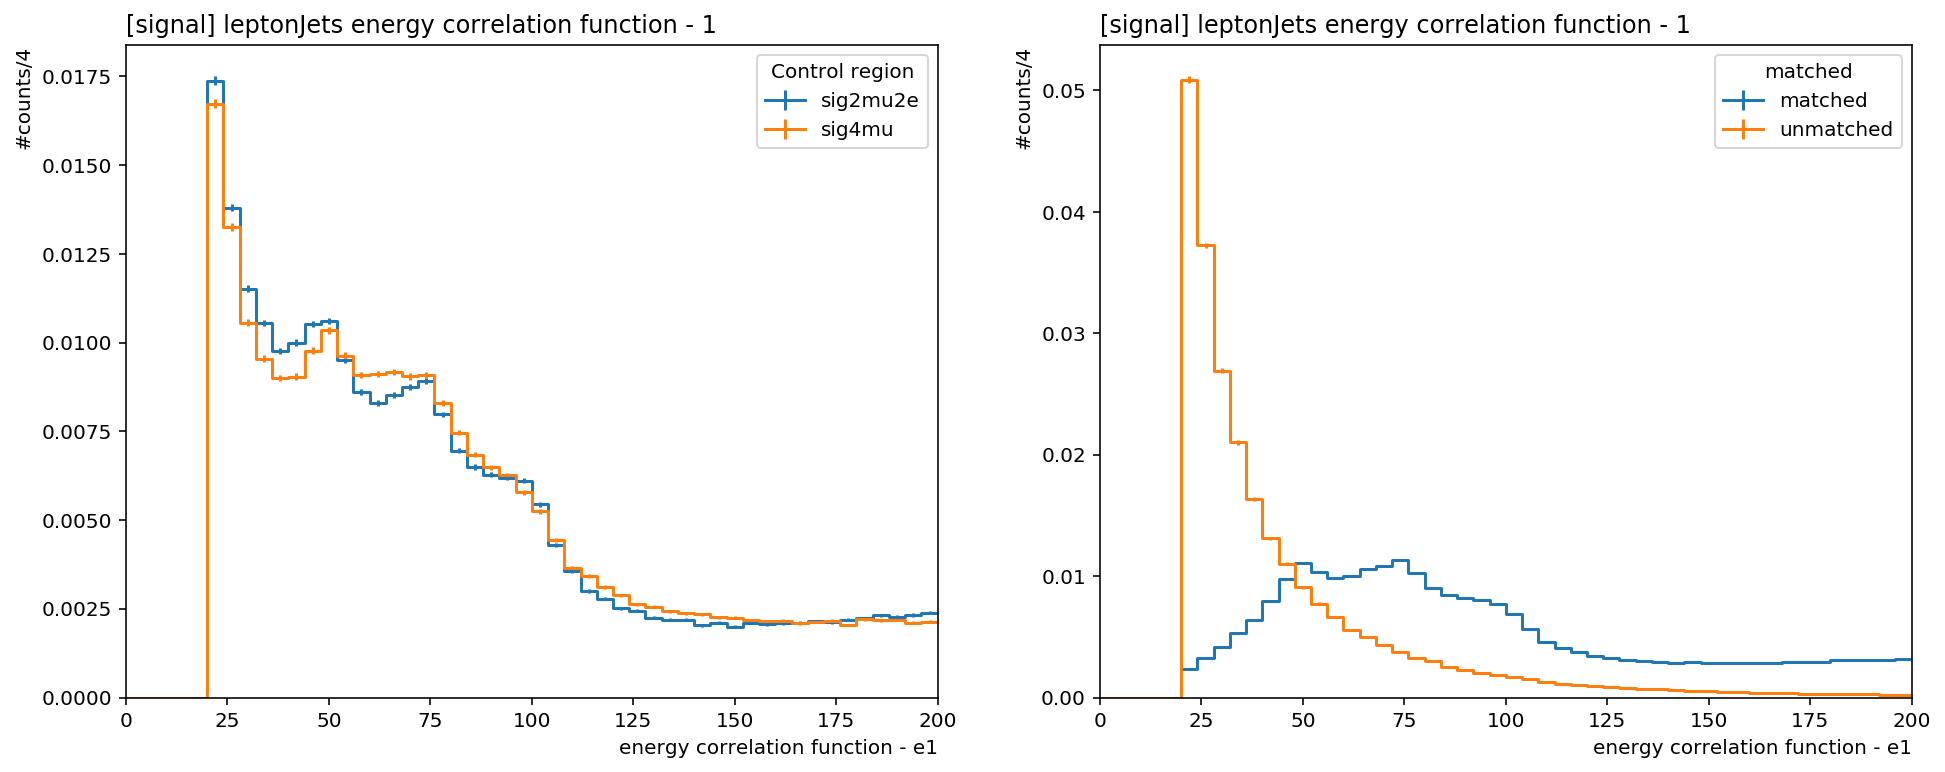

In [21]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe1'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['ecfe1'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets energy correlation function - 1', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

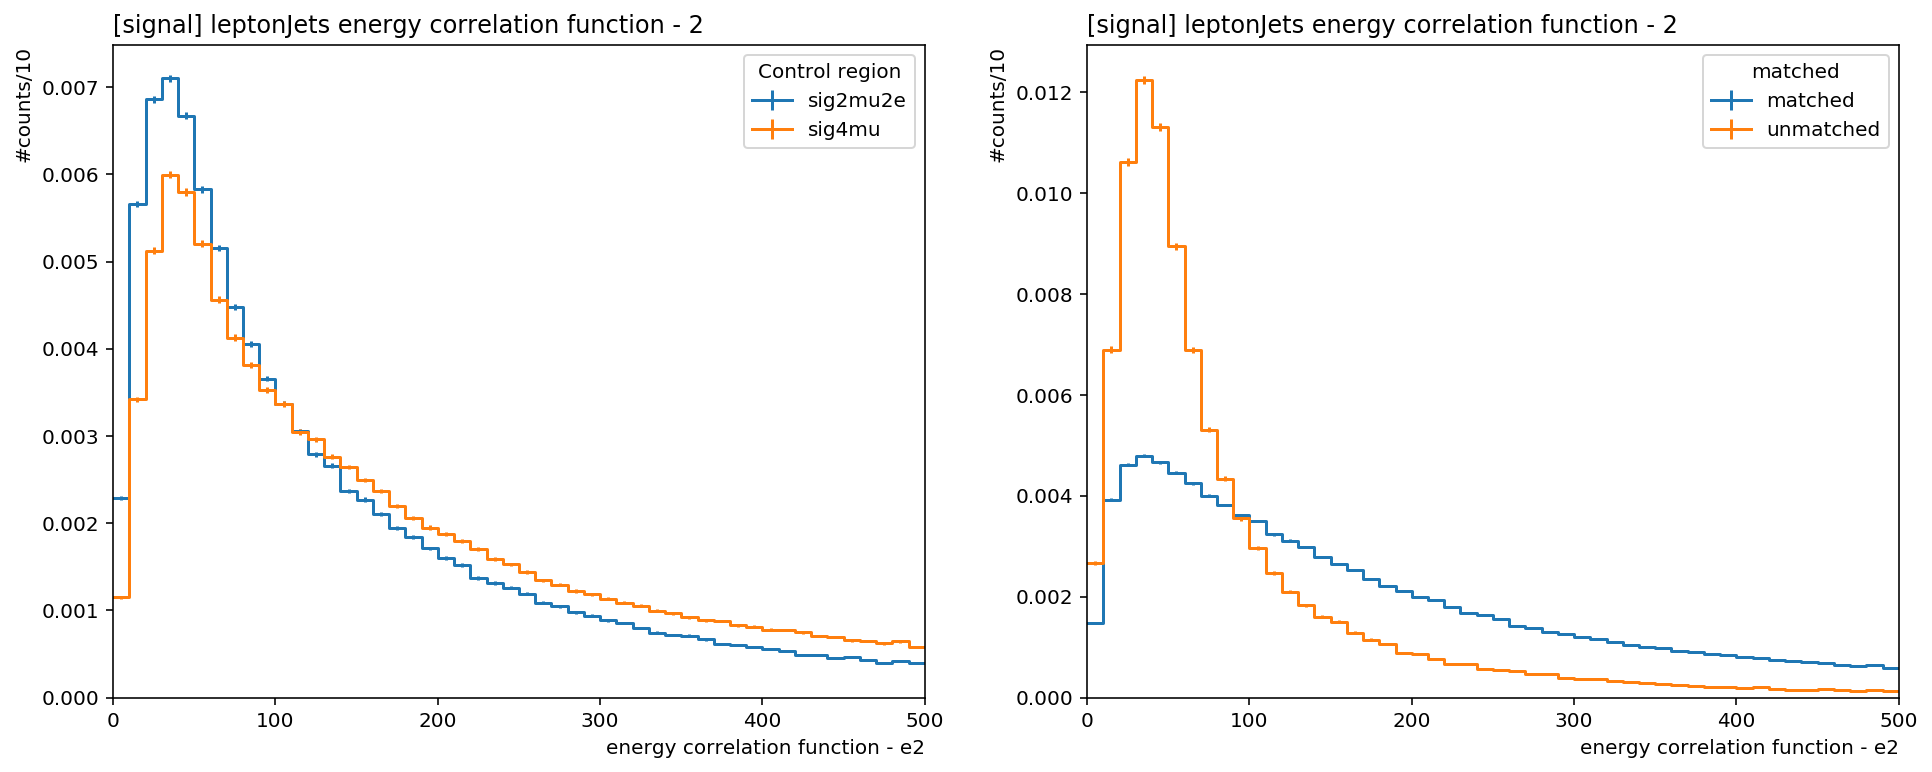

In [22]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe2'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['ecfe2'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets energy correlation function - 2', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

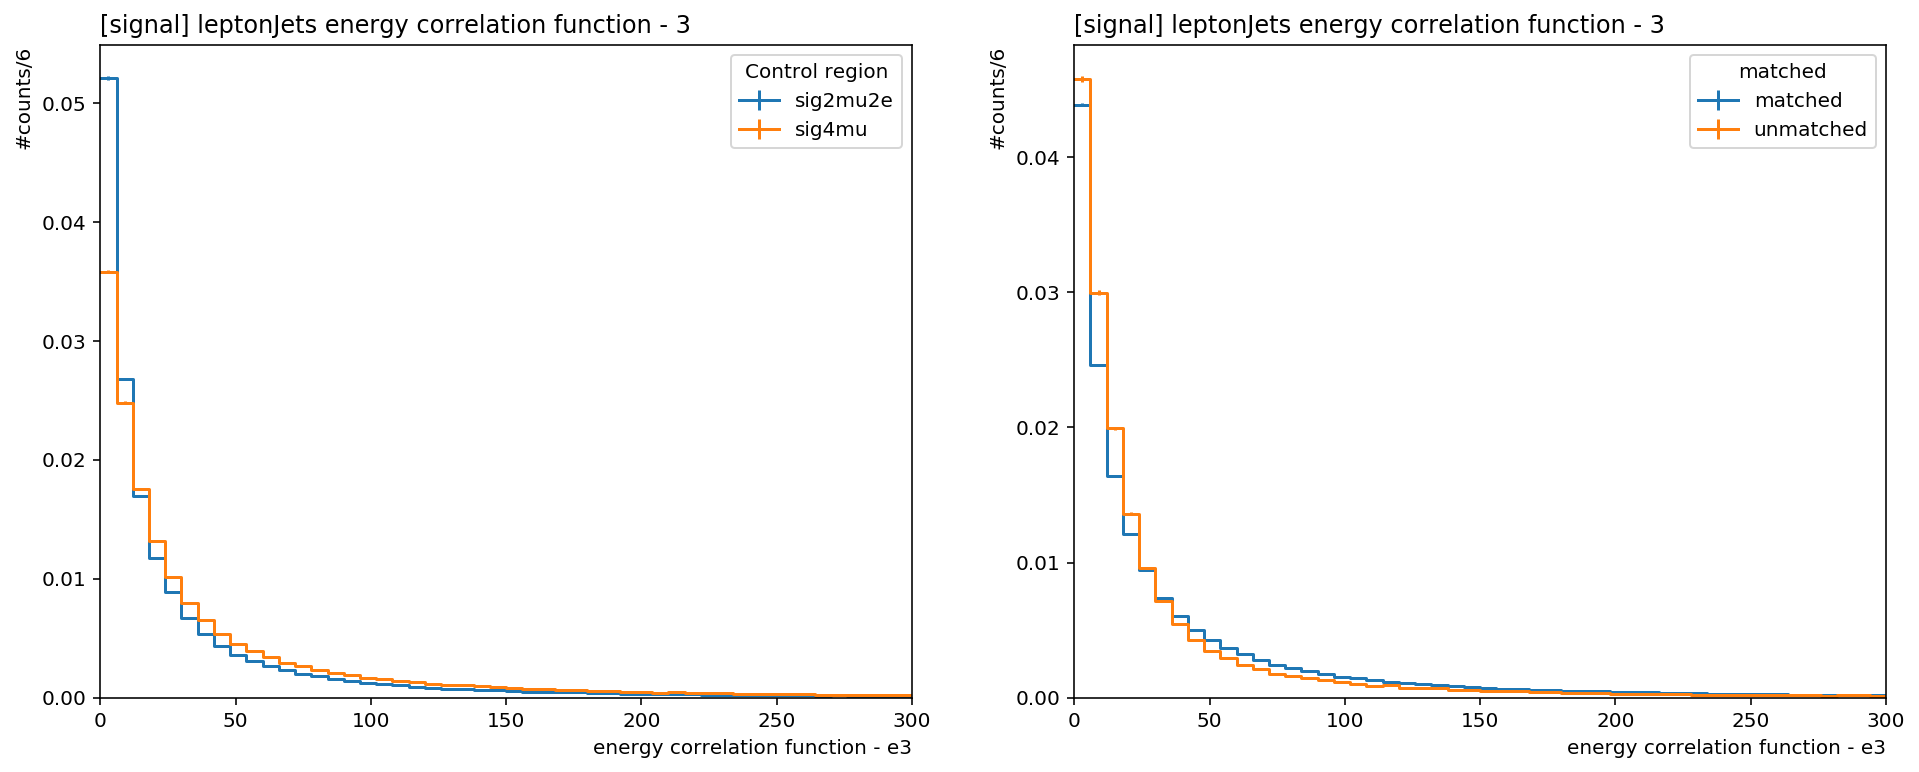

In [23]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['ecfe3'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['ecfe3'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets energy correlation function - 3', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

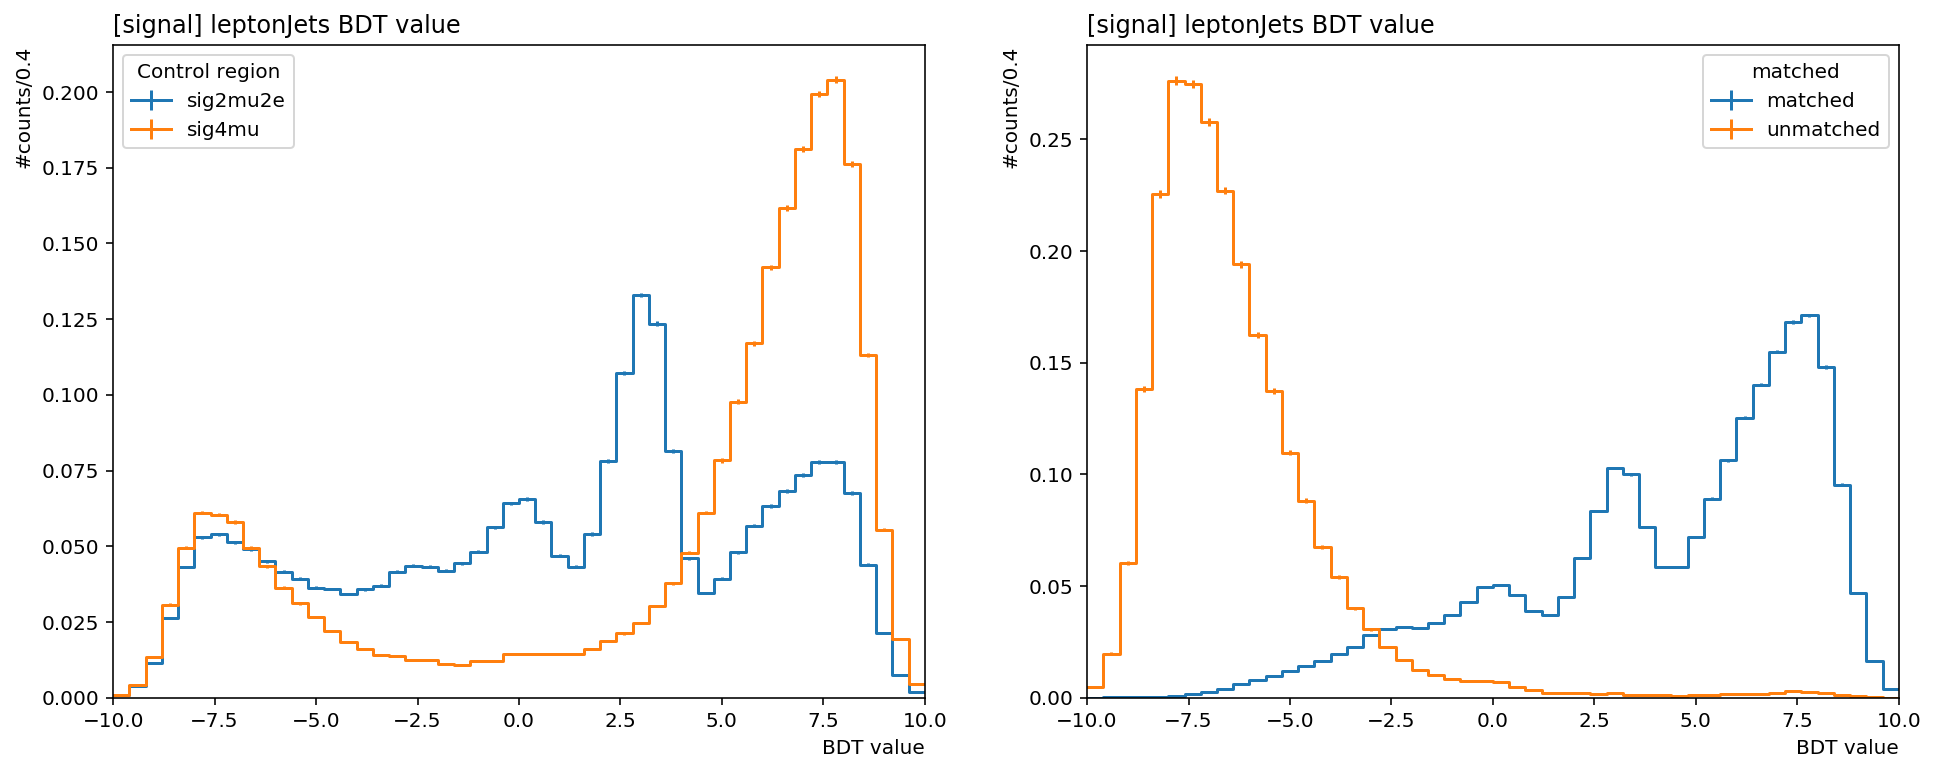

In [24]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
fig, ax, _ = hist.plot1d(output['mva'].project('match'), overlay='dataset', ax=axes[0], density=True)
fig, ax, _ = hist.plot1d(output['mva'].project('dataset'), overlay='match', ax=axes[1], density=True)

for ax in axes:
    ax.set_title('[signal] leptonJets BDT value', x=0.0, ha="left")
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leptonJet pair (lead, sublead)
- invariant mass
- delta phi

In [25]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 300)
        masss_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 1200)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("A.U./10GeV", dataset_axis, mass_axis),
            'masss': hist.Hist("A.U./10GeV", dataset_axis, masss_axis),
            'dphi': hist.Hist("A.U./$\pi$/50", dataset_axis, dphi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))
            
            output['mass'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['masss'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['dphi'].fill(dataset=dataset, dphi=dphi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [26]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 300/300 [00:19<00:00, 15.66items/s]


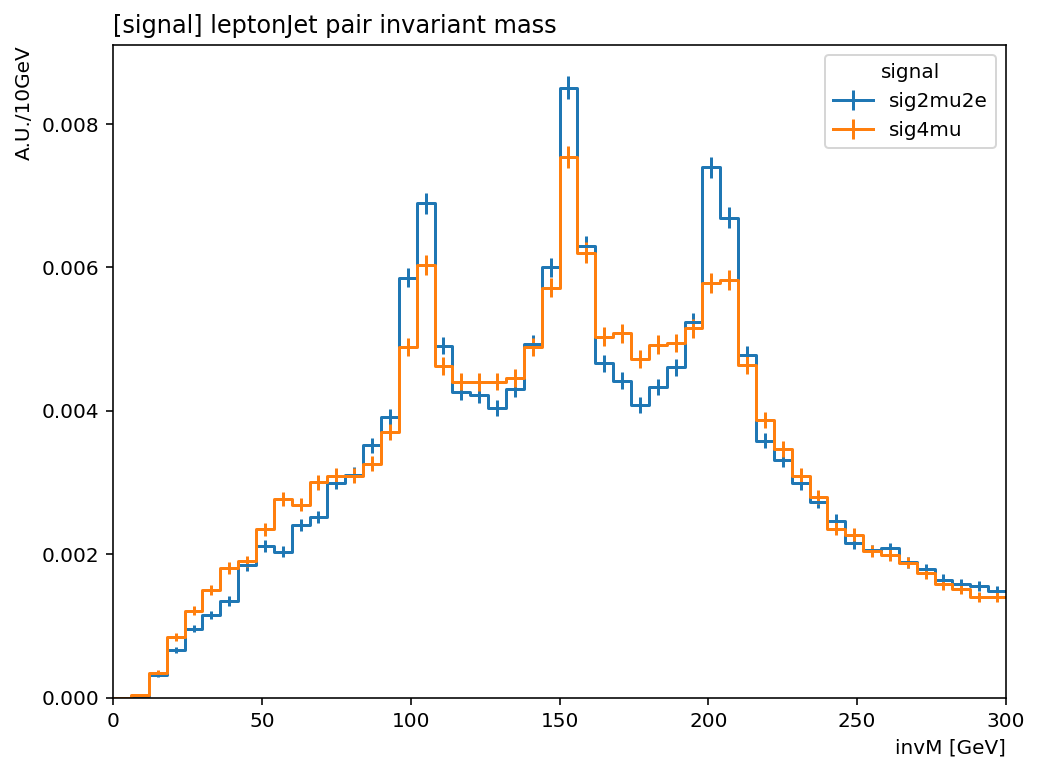

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mass'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

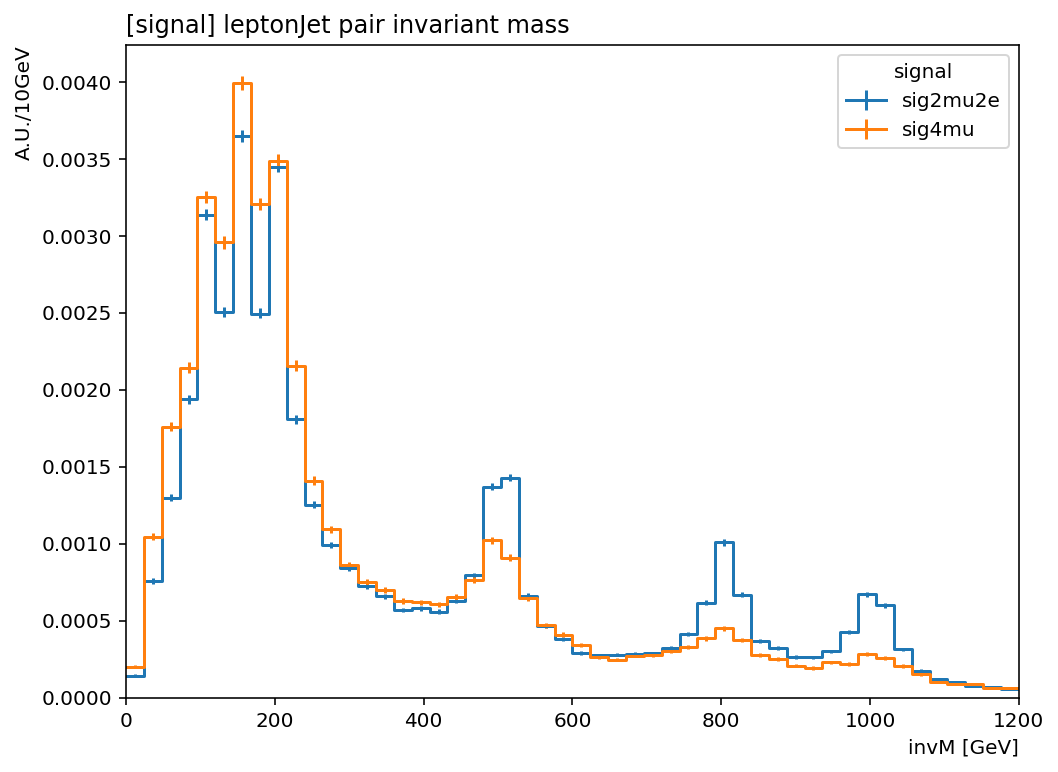

In [28]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masss'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

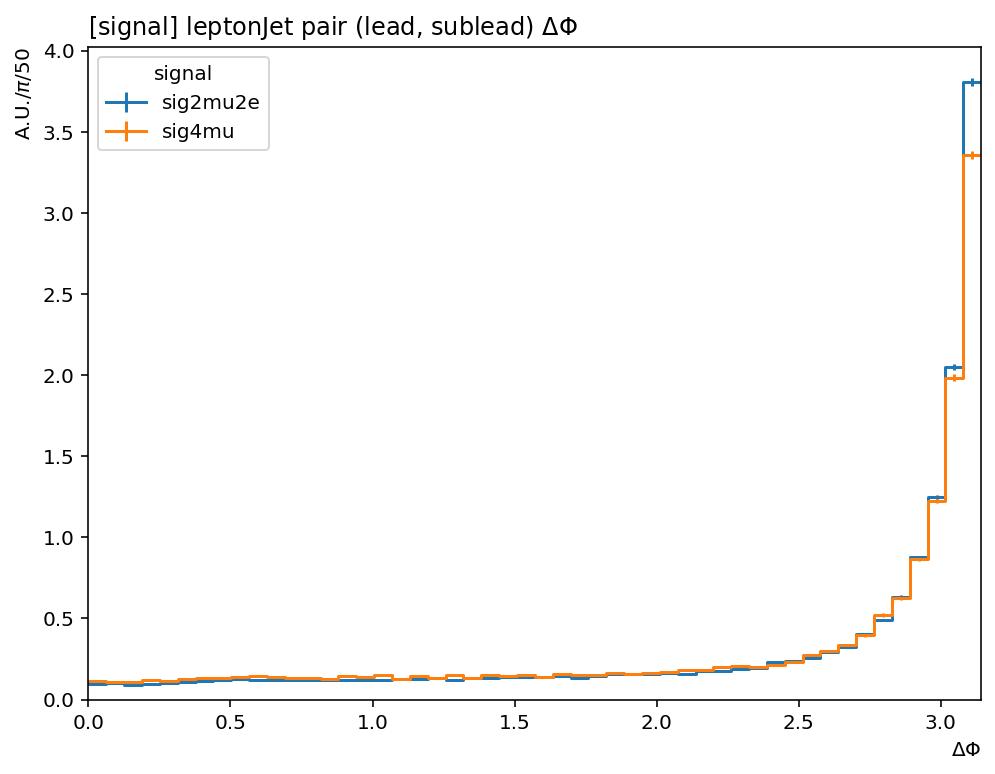

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

only those matched with gen dark photons!

In [30]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        mass_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 300)
        masss_axis = hist.Bin("mass", "invM [GeV]", 50, 0, 1200)
        dphi_axis = hist.Bin('dphi', "$\Delta\Phi$", 50, 0, 3.142)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("A.U./10GeV", dataset_axis, mass_axis),
            'masss': hist.Hist("A.U./10GeV", dataset_axis, masss_axis),
            'dphi': hist.Hist("A.U./$\pi$/50", dataset_axis, dphi_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'],
            py=df['gen_p4.fCoordinates.fY'],
            pz=df['gen_p4.fCoordinates.fZ'],
            energy=df['gen_p4.fCoordinates.fT'],
            pid=df['gen_pid']
        )
        darkphotons = genparticles[genparticles.pid==32]
        matchmask = leptonjets.match(darkphotons, deltaRCut=0.3)
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[matchmask][metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            dphi = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))
            
            output['mass'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['masss'].fill(dataset=dataset, mass=leadingLjPair.mass.flatten())
            output['dphi'].fill(dataset=dataset, dphi=dphi.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [31]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing:   0%|          | 0/300 [00:00<?, ?items/s]/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/analysis_objects/JaggedCandidateArray.py:22: RuntimeWarning: divide by zero encountered in true_divide
  return np.arcsinh(pz / pT)
/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7

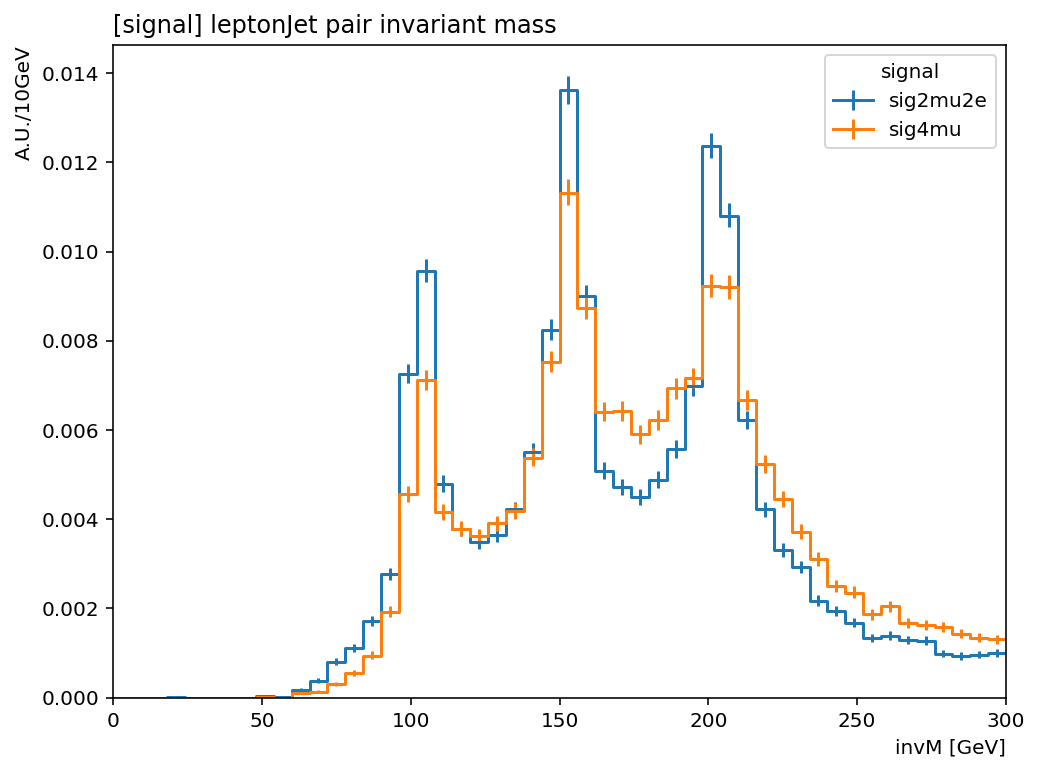

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['mass'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

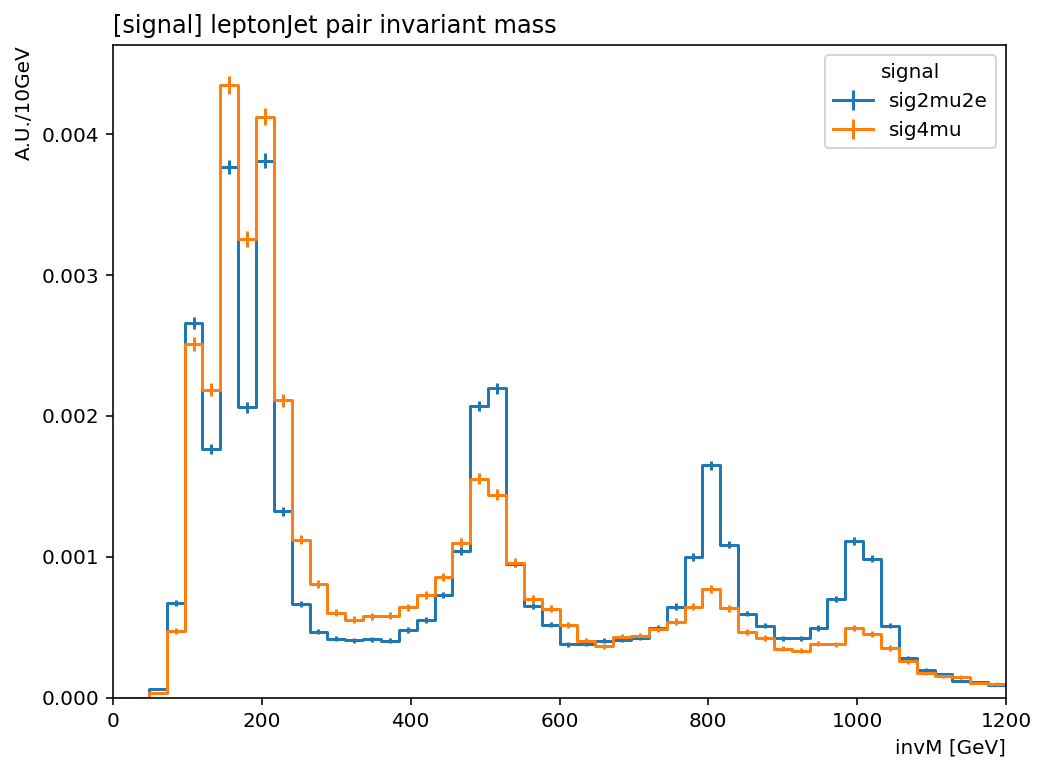

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['masss'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair invariant mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

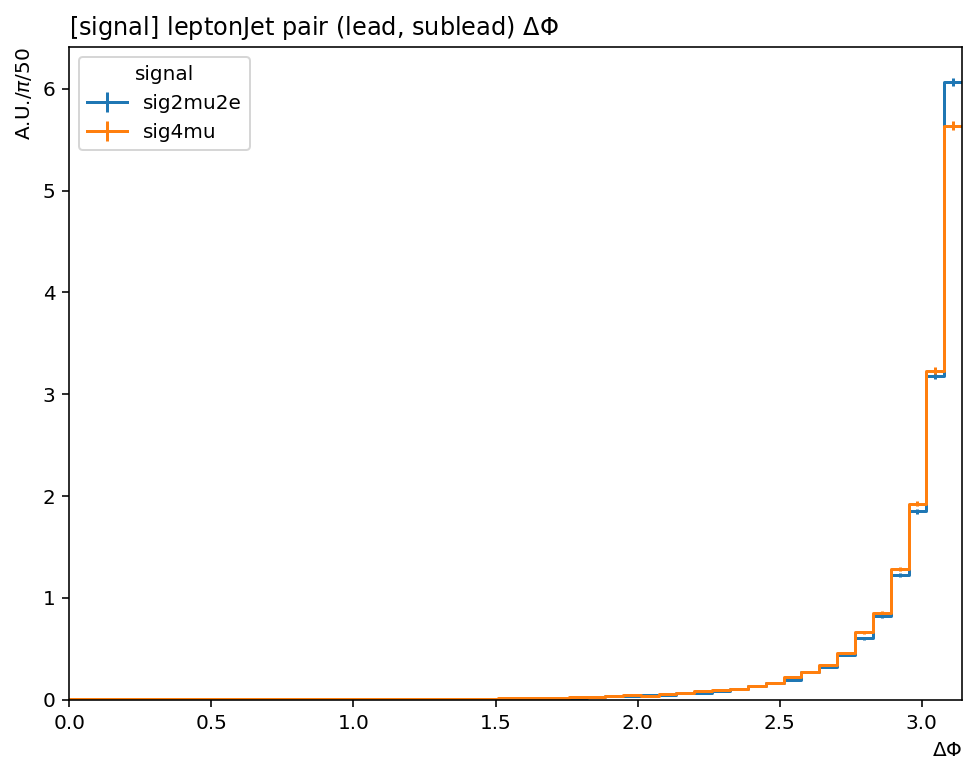

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['dphi'], overlay='dataset', ax=ax, density=True)
ax.set_title('[signal] leptonJet pair (lead, sublead) $\Delta\Phi$', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### leading and subleading leptonJets kinematics
- pT, eta

In [37]:
class LeptonJetPairProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        pt_axis      = hist.Bin("pt", "pT [GeV]", 50, 0, 800)
        eta_axis     = hist.Bin("eta", 'eta', 50, -2.4, 2.4)
        order_axis   = hist.Cat('order', 'pT order')
        
        self._accumulator = processor.dict_accumulator({
            'pt': hist.Hist("A.U./16GeV", dataset_axis, pt_axis, order_axis),
            'eta': hist.Hist("A.U./0.096", dataset_axis, eta_axis, order_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        metfiltermask = np.logical_or.reduce([df[mf] for mf in MetFilters])
        leptonjets = leptonjets[metfiltermask]
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        leptonjetpair = dileptonjets.distincts()
        sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
        if sumpt.size!=0:
            leadingLjPair = leptonjetpair[sumpt.argmax()]
            _comp = leadingLjPair.i0.pt<leadingLjPair.i1.pt
            leadlj = leadingLjPair.i0*(~_comp)+leadingLjPair.i1*(_comp)
            subllj = leadingLjPair.i0*(_comp)+leadingLjPair.i1*(~_comp)
            
            output['pt'].fill(dataset=dataset, pt=leadlj.p4.pt.flatten(), order='leading')
            output['eta'].fill(dataset=dataset, eta=leadlj.p4.eta.flatten(), order='leading')
            output['pt'].fill(dataset=dataset, pt=subllj.p4.pt.flatten(), order='subleading')
            output['eta'].fill(dataset=dataset, eta=subllj.p4.eta.flatten(), order='subleading')
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [38]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetPairProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 300/300 [00:20<00:00, 14.89items/s]


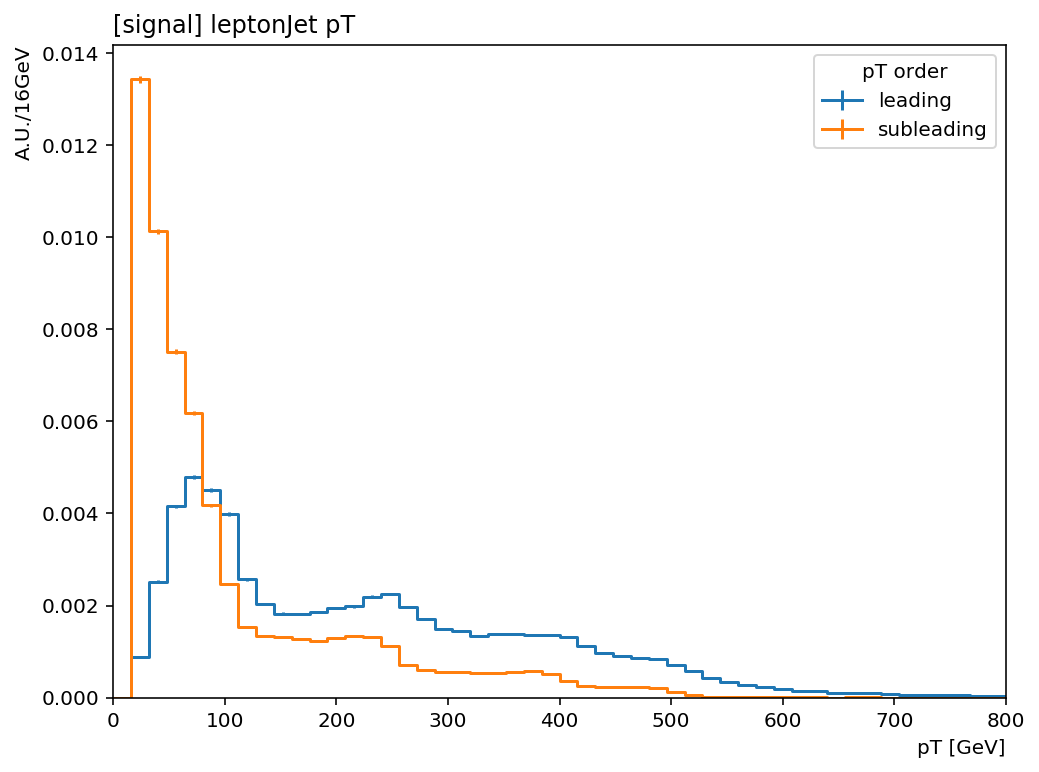

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['pt'].project('dataset'), overlay='order', ax=ax, density=True)
ax.set_title('[signal] leptonJet pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

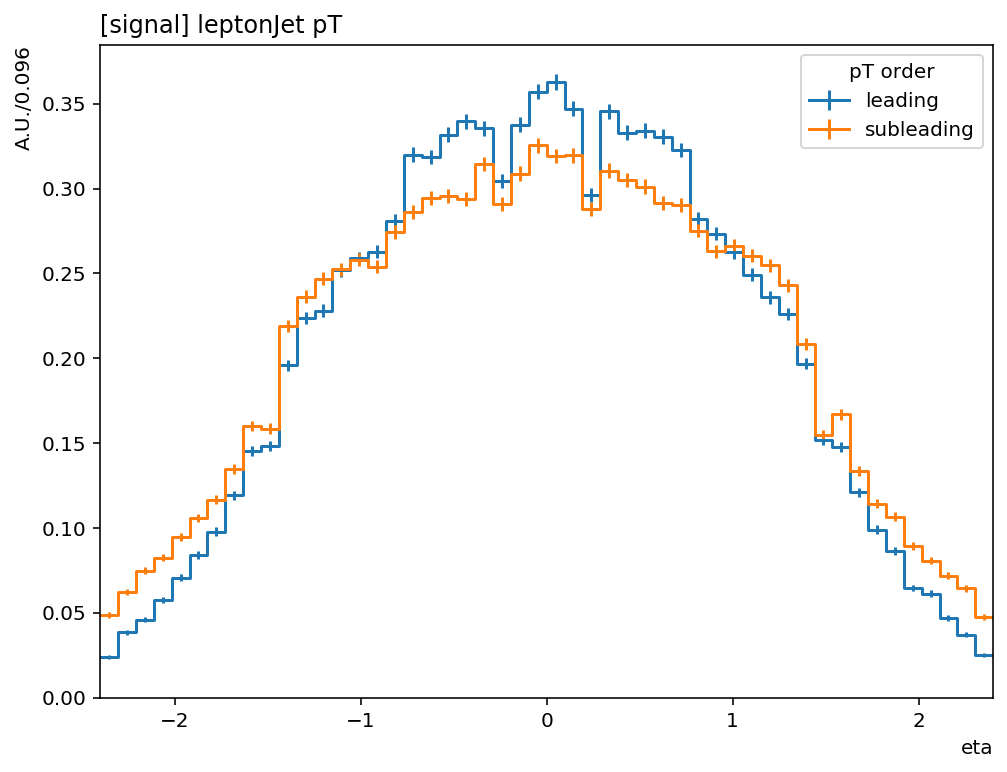

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
fig, ax, _ = hist.plot1d(output['eta'].project('dataset'), overlay='order', ax=ax, density=True)
ax.set_title('[signal] leptonJet pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

---